# Exploring Stability within Same-Tissue Cancer Cell Lines

- **License:** [MIT License](https://opensource.org/licenses/MIT)
- **Version:** 0.2
- **Edit Log:** 
    - 2024-01-19: Initial version of the notebook
    - 2024-02-21: Revised the notes 

**Data Information:**

The data used here comes from the previous notebook where the `questvar` frame has been run over all cancer cell line pairs (around 64K pairs). The resulting data are saved in multiple different formats to facilitate easy handling and gives more opportunity to display different results with different questions. The data is saved in the `data/results/` folder. The protein status matrix table will be used to calculate the protein status data per same-tissue groupings, while the protein status summary table will be used to compare the pair similarity between same-tissue groupings. 

**Notebook Summary:**

This notebook is the continuation of the previous notebook where the `questvar` frame has been run over all cancer cell line pairs, asking a different question than the previous notebook where we've explored the stability in all cancer cell lines. Goal of this notebook is to exploring the stable core-proteme within cancer cell lines per same-tissue groupings and compare the similarity between same-tissue groupings. The notebook is divided into three sections. In the first section, I will be looking at the pair's equivalence percent and summarize them per same-tissue groupings to see which tissue has higher stability within. In the second section, I will extract the quantitatively stable and variable proteins per same-tissue groupings and explore the direct protein identification within and between same-tissue groupings. In the last section, I will be creating a multi-query enrichment from the stable proteins per same-tissue groupings and explore their biological pathways.

## Setup Notebook

This part is a standard for my notebooks, where I import the all used libraries, set the design of the notebook, and define the paths for data and figures. 

> **Note:** The HTML rendering of this notebook will not show the code cells by default, but the code can be visible by clicking the "code" buttons aligned on the right.

### Libraries Used

In [1]:
import os
import sys
import feather
import warnings

import numpy as np # Numerical computing
import pandas as pd # Data manipulation
import polars as pl # Rust-based pandas-like library

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 
import matplotlib.ticker as mtick # Format tick labels

from upsetplot import from_contents, plot # Specialized Plotting for Set-Related Data
import PyComplexHeatmap as pch # Complex Heatmaps in Python

sys.path.append('../')
# Custom functions
from questvar import utils, enrich, plots 
warnings.filterwarnings('ignore')
nbStartTime = utils.getTime()

### Notebook's Styling

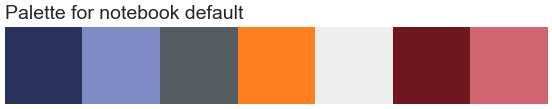

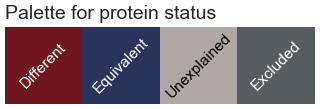

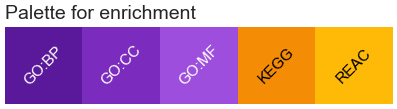

In [2]:
### Notebook Configuration
## Colors
def_colors = ["#29335c","#7e8cc6","#565d61","#ff8020","#eeeeee","#70161e","#d06770"]

# Color dict for the protein status
status_colors = {
    "Different": "#70161e",
    "Equivalent": "#29335c",
    "Unexplained": "#b1a7a6",
    "Excluded": "#565d61"
}
# Color dict for enrichment
enrichment_palette = {
    "GO:BP": "#5a189a",
    "GO:CC": "#7b2cbf",
    "GO:MF": "#9d4edd",
    "KEGG":  "#f48c06",
    "REAC":  "#ffba08"
}

## Configure some general styling
# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["png", "pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300


## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

## Color Palettes used
# Default colors
plots.color_palette(
    def_colors,
    name = "notebook default"
)

# Protein status colors
plots.color_palette(
    status_colors,
    name = "protein status",
)

# Enrichment colors
plots.color_palette(
    enrichment_palette,
    name = "enrichment"
)

### Data and Result Paths

The data and figure related paths are defined here. It will point to the input file paths as well as notebook specific output paths to distinguish between similar application result related notebooks. The `notebook_name` variable contains the specific identifier that will be used to create the output folder for this notebook. For the output the data `data/results/{notebook_name}/` will be used and for the figures `figures/{notebook_name}/` will be used. 

Similar to other notebooks the notebook's figure path will contain subfolders specific to the formats user selected to save the figures in for instance if `['png', 'pdf']` is selected then there will be two subfolders `png` and `pdf` in the `figures/{notebook_name}/` saving the figures in png and pdf formats respectively.

In [3]:
# Establish notebook specific paths

notebook_name = "TissueStability"

data_path = "./data/"                           # Main data folder
fig_path = f"./figures/{notebook_name}/"        # Figures folder
proces_path = f"{data_path}processed/"
input_path = f"{data_path}results/"
output_path = f"{data_path}results/{notebook_name}/"
supp_path = f"{data_path}supplementary/"        # Supplementary data folder (for Manuscript)

# Check if the paths exist
if not os.path.exists(input_path):
    raise ValueError(
        f"the input folder doesn't exists, run the notebook '02-Create_Input_and_Run_Tests.ipynb' first"
    )

# Create folders for various outputs
for i in [output_path]:
    if not os.path.exists(i):
        os.makedirs(i)   

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = fig_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

## Setup the Data

Opening and setting up the data that will be used in the notebook, produced in the previous notebook.


### Read the Metadata

The metadata used for cell line sample information is read from the `data/processed/metadata.feather` file.

In [4]:
metadata = feather.read_dataframe(
    f"{proces_path}metadata.feather"
)
print(f"Data Shape: {metadata.shape}")
metadata.head()

Data Shape: (360, 10)


SIDM   Cell_line System_name Tissue_type  \
0  SIDM00872     HCC1954      Breast      Breast   
1  SIDM00875     HCC1806      Breast      Breast   
2  SIDM00879     HCC1500      Breast      Breast   
3  SIDM00629  MDA-MB-436      Breast      Breast   
4  SIDM00122      BT-549      Breast      Breast   

                       Cancer_type                   Cancer_subtype  \
0  Breast Ductal Carcinoma In Situ  Breast Ductal Carcinoma In Situ   
1  Breast Ductal Carcinoma In Situ  Breast Ductal Carcinoma In Situ   
2  Breast Ductal Carcinoma In Situ  Breast Ductal Carcinoma In Situ   
3        Invasive Breast Carcinoma   Breast Invasive Carcinoma, NOS   
4        Invasive Breast Carcinoma   Breast Invasive Carcinoma, NOS   

    Collection_site      Status    Age     Sex  
0            Breast     Primary  Adult  Female  
1            Breast     Primary  Adult  Female  
2            Breast     Primary  Adult  Female  
3  Pleural_effusion  Metastatic  Adult  Female  
4            Breast     Primary  Adult  Female

### Expanded Protein Information Data

The expanded protein information data is read from the `data/processed/protein_expanded_data.feather`, which contains the protein information, with mean, cv, and rank columns, as well as the average protein intensity values for each cell line.

In [5]:
protein_data = feather.read_dataframe(
    f"{input_path}protein_expanded_data.feather"
)

# Get the unique proteins
allProteins = protein_data["entry"].unique()

print(f"Data Shape: {protein_data.shape}")
protein_data.head()

Data Shape: (7975, 367)


entry    entryName                         proteinDescription geneName  \
0  Q9Y651  SOX21_HUMAN                Transcription factor SOX-21    SOX21   
1  P37108  SRP14_HUMAN  ignal recognition particle 14 kDa protein    SRP14   
2  Q96JP5  ZFP91_HUMAN          E3 ubiquitin-protein ligase ZFP91    ZFP91   
3  Q9Y4H2   IRS2_HUMAN               Insulin receptor substrate 2     IRS2   
4  P36578    RL4_HUMAN        Large ribosomal subunit protein uL4     RPL4   

    Mean      Rank      CV  SIDM00018  SIDM00023  SIDM00043  SIDM00045  \
0 2.6725 5215.0000 34.3192        NaN        NaN        NaN        NaN   
1 6.5487  423.0000 39.5648   137.3901   110.0761   107.8404    73.9405   
2 3.5780 3040.0000 30.8813    12.4335    19.3804    20.5577     8.6273   
3 2.3271 6163.0000 66.4872        NaN     5.1058        NaN        NaN   
4 7.5242  197.0000 30.6928   242.9197   210.8121   173.7156   299.7880   

   SIDM00050  ...  SIDM01178  SIDM01183  SIDM01186  SIDM01187  SIDM01191  \
0        NaN  ...        NaN        NaN        NaN        NaN        NaN   
1    63.5611  ...    66.4011    94.4678   144.4451    90.0577    62.1151   
2    15.3369  ...    14.0515    11.1489    12.7769        NaN    16.2813   
3        NaN  ...        NaN     4.2346        NaN        NaN        NaN   
4   239.7711  ...   246.7877   148.8203   146.9704   176.2236   213.4566   

   SIDM01194  SIDM01196  SIDM01203  SIDM01206  SIDM01219  SIDM01247  SIDM01248  
0        NaN        NaN        NaN     5.6178        NaN        NaN        NaN  
1    70.5387    68.0420    43.2385   116.7107   227.9230   130.3740    80.4335  
2    10.3848        NaN     4.2041     9.3307     9.3485    12.5094    31.3789  
3     0.7251        NaN     3.1175        NaN        NaN        NaN        NaN  
4   180.7671   198.1770   282.6860   187.0721   253.5591   148.1466   204.8152  

[5 rows x 367 columns]

### Groupings Data

The groupings data is read from the `data/processed/groupings.feather` file, which contains the pair specific copy of metadata for easy access for subsetting and creating groups for different questions.

In [6]:
# Groupings
groupings = feather.read_dataframe(
    f"{input_path}groupings.feather"
)

print(f"Data Shape: {groupings.shape}")
groupings.head()

Data Shape: (64620, 20)


S1 Cell_line_S1 System_name_S1 Tissue_type_S1  \
0  SIDM00872      HCC1954         Breast         Breast   
1  SIDM00872      HCC1954         Breast         Breast   
2  SIDM00872      HCC1954         Breast         Breast   
3  SIDM00872      HCC1954         Breast         Breast   
4  SIDM00872      HCC1954         Breast         Breast   

                    Cancer_type_S1                Cancer_subtype_S1  \
0  Breast Ductal Carcinoma In Situ  Breast Ductal Carcinoma In Situ   
1  Breast Ductal Carcinoma In Situ  Breast Ductal Carcinoma In Situ   
2  Breast Ductal Carcinoma In Situ  Breast Ductal Carcinoma In Situ   
3  Breast Ductal Carcinoma In Situ  Breast Ductal Carcinoma In Situ   
4  Breast Ductal Carcinoma In Situ  Breast Ductal Carcinoma In Situ   

  Collection_site_S1 Status_S1 Age_S1  Sex_S1         S2 Cell_line_S2  \
0             Breast   Primary  Adult  Female  SIDM00875      HCC1806   
1             Breast   Primary  Adult  Female  SIDM00879      HCC1500   
2             Breast   Primary  Adult  Female  SIDM00629   MDA-MB-436   
3             Breast   Primary  Adult  Female  SIDM00122       BT-549   
4             Breast   Primary  Adult  Female  SIDM00135     Hs-578-T   

  System_name_S2 Tissue_type_S2                   Cancer_type_S2  \
0         Breast         Breast  Breast Ductal Carcinoma In Situ   
1         Breast         Breast  Breast Ductal Carcinoma In Situ   
2         Breast         Breast        Invasive Breast Carcinoma   
3         Breast         Breast        Invasive Breast Carcinoma   
4         Breast         Breast        Invasive Breast Carcinoma   

                 Cancer_subtype_S2 Collection_site_S2   Status_S2 Age_S2  \
0  Breast Ductal Carcinoma In Situ             Breast     Primary  Adult   
1  Breast Ductal Carcinoma In Situ             Breast     Primary  Adult   
2   Breast Invasive Carcinoma, NOS   Pleural_effusion  Metastatic  Adult   
3   Breast Invasive Carcinoma, NOS             Breast     Primary  Adult   
4   Breast Invasive Carcinoma, NOS             Breast     Primary  Adult   

   Sex_S2  
0  Female  
1  Female  
2  Female  
3  Female  
4  Female

### Combined Labels Data

The combined labels data is read from the `data/processed/labeled_pairs_groupings.feather` file, which contains simplified labels that are combined version of S1 and S2 specific metadata columns as an additional table to make the data handling easier.

There are two versions of the same columns, a column with `_Compare` addition and without. The columns with `_Compare` addition keep the order of the label as S1 and S2, where the other version sorts to ensure the label is always in the same order.

In [7]:
# Combined Labels
combined_labels = feather.read_dataframe(
    f"{input_path}labeled_pairs_groupings.feather"
)

print(f"Data Shape: {combined_labels.shape}")
combined_labels.head()

Data Shape: (64620, 18)


S1         S2 Sex_Compare     Sex Age_Compare    Age  \
0  SIDM00872  SIDM00875      Female  Female       Adult  Adult   
1  SIDM00872  SIDM00879      Female  Female       Adult  Adult   
2  SIDM00872  SIDM00629      Female  Female       Adult  Adult   
3  SIDM00872  SIDM00122      Female  Female       Adult  Adult   
4  SIDM00872  SIDM00135      Female  Female       Adult  Adult   

          Status_Compare                 Status                Site_Compare  \
0                Primary                Primary                      Breast   
1                Primary                Primary                      Breast   
2  Primary vs Metastatic  Metastatic vs Primary  Breast vs Pleural_effusion   
3                Primary                Primary                      Breast   
4                Primary                Primary                      Breast   

                         Site System_Compare  System Tissue_Compare  Tissue  \
0                      Breast         Breast  Breast         Breast  Breast   
1                      Breast         Breast  Breast         Breast  Breast   
2  Breast vs Pleural_effusion         Breast  Breast         Breast  Breast   
3                      Breast         Breast  Breast         Breast  Breast   
4                      Breast         Breast  Breast         Breast  Breast   

                                      Cancer_Compare  \
0                    Breast Ductal Carcinoma In Situ   
1                    Breast Ductal Carcinoma In Situ   
2  Breast Ductal Carcinoma In Situ vs Invasive Br...   
3  Breast Ductal Carcinoma In Situ vs Invasive Br...   
4  Breast Ductal Carcinoma In Situ vs Invasive Br...   

                                              Cancer  \
0                    Breast Ductal Carcinoma In Situ   
1                    Breast Ductal Carcinoma In Situ   
2  Breast Ductal Carcinoma In Situ vs Invasive Br...   
3  Breast Ductal Carcinoma In Situ vs Invasive Br...   
4  Breast Ductal Carcinoma In Situ vs Invasive Br...   

                                     Subtype_Compare  \
0                    Breast Ductal Carcinoma In Situ   
1                    Breast Ductal Carcinoma In Situ   
2  Breast Ductal Carcinoma In Situ vs Breast Inva...   
3  Breast Ductal Carcinoma In Situ vs Breast Inva...   
4  Breast Ductal Carcinoma In Situ vs Breast Inva...   

                                             Subtype  
0                    Breast Ductal Carcinoma In Situ  
1                    Breast Ductal Carcinoma In Situ  
2  Breast Ductal Carcinoma In Situ vs Breast Inva...  
3  Breast Ductal Carcinoma In Situ vs Breast Inva...  
4  Breast Ductal Carcinoma In Situ vs Breast Inva...

### Pair Specific Summary Table

The pair specific summary table is read from the `data/results/protein_status_summary.feather` file, which contains the pair specific summary table for all pairs. The summary table contains the pair's equivalence percent, protein status, and protein status summary. This table will be used to create the same-tissue groupings' summary table and used to create a high-level same-tissue similarity plot.

In [8]:
# Read the status data = Pairs's Protein Status Percentages Ux-Df-Eq ...
status_data = feather.read_dataframe(
    f"{input_path}protein_status_summary.feather"
)
status_data = status_data.sort_values(["S1", "S2"]).reset_index(drop=True)

print("Data Shape:", status_data.shape)
status_data.head()

Data Shape: (64620, 10)


S1         S2    Ms    Ux    Df    Eq  tested     %Ux     %Df  \
0  SIDM00018  SIDM00050  5141  1119   677  1038    2834 39.4848 23.8885   
1  SIDM00018  SIDM00051  5428   919   928   700    2547 36.0817 36.4350   
2  SIDM00018  SIDM00055  5113  1000   747  1115    2862 34.9406 26.1006   
3  SIDM00018  SIDM00080  5368  1027   924   656    2607 39.3939 35.4430   
4  SIDM00018  SIDM00081  5519   716  1218   522    2456 29.1531 49.5928   

      %Eq  
0 36.6267  
1 27.4833  
2 38.9588  
3 25.1630  
4 21.2541

### Protein Status Matrix Table

The protein status matrix table is read from the `data/results/protein_status_matrix.feather` file, which contains the protein-pair status values in a very large matrix. This table will be used to calculate protein specific summary table for same-tissue groupings for the protein specific part of the analysis. 

In [9]:
# Prepare Protein Status Summary for Equivalent Percentage of Pairs in System Groups
protStatusDF = pl.read_ipc( 
    f"{input_path}protein_status_matrix.feather",
    memory_map=False
).sort(["S1", "S2"])
# Get the info specific to the system
info = protStatusDF.select(["S1", "S2"])
# Merge info with groupings data on S1 and S2
info = info.join(
    pl.DataFrame(groupings), 
    on=["S1", "S2"], 
    how="inner", 
).sort(["S1", "S2"])

print("Check if the S1 and S2 Matches by looking for any mismatches.")
print("# of mismatch in S1:", (info["S1"] != protStatusDF["S1"]).sum())
print("# of mismatch in S2:", (info["S2"] != protStatusDF["S2"]).sum())

Check if the S1 and S2 Matches by looking for any mismatches.
# of mismatch in S1: 0
# of mismatch in S2: 0


# Pair-Specific Look at Same-Tissue Groupings

## High-level Same-Tissue Similarity

### Compile the Data for the Figure

This step I will create the data for plotting 3 subplots that will help me show the same-tissue groups similarity. 

- Figure 1: Pair composition indicates (Stacked Barh (Same/Different))
- Figure 2: Mean Protein Percentage of Protein Status (Stacked Barh (Different/Unexplained/Equivalent))
- Figure 3: Number of proteins tested per pairs (Boxplot-h)

In [10]:
# Subset for same tissue type pairings
# Subset the grouping pair that has same tissue type
same_tissue_groupings = groupings[
    (groupings["Tissue_type_S1"] == groupings["Tissue_type_S2"])
]
print("Same Tissue Groupings Shape:", same_tissue_groupings.shape)

# Subset the status data for same tissue type pairings
tmp = pd.merge(
    status_data,
    combined_labels[["S1", "S2", "Tissue"]],
    on=["S1", "S2"],
)
same_tissue_status_data = tmp[~tmp["Tissue"].str.contains(" vs ")]

Same Tissue Groupings Shape: (4454, 20)


There are 4454 pairs that both cell-line originate from the same-tissue. Let's build the data that can show the number of pairs per tissue, as well as proportion of those pairs that come from same subtype and different subtypes. 

In [11]:
# Figure 3A - Tissue Group Composition (Same or Different Cancer Subtype Pairs)
fig3A_data = pd.DataFrame(
    [
        same_tissue_groupings.groupby("Tissue_type_S1").apply(
            lambda x: len(x[x["Cancer_subtype_S1"] == x["Cancer_subtype_S2"]]),
        ),
        same_tissue_groupings.groupby("Tissue_type_S1").apply(
            lambda x: len(x[x["Cancer_subtype_S1"] != x["Cancer_subtype_S2"]]),
        )
    ],
    index=["Same", "Different"]
).T # Need to be ordered to same order
table3_data = fig3A_data.copy()
# Get the totals
pair_totals = fig3A_data.sum(axis=1)
# Update the counts to be percentages
fig3A_data = fig3A_data.apply(lambda x: x / x.sum() * 100, axis=1)

fig3A_data["#ofPairs"] = pair_totals
fig3A_data[["#ofPairs", "Same", "Different"]].sort_values("#ofPairs", ascending=False)

#ofPairs     Same  Different
Tissue_type_S1                              
Lymphoid            2016   5.6548    94.3452
Lung                 666  11.4114    88.5886
Stomach              378  13.4921    86.5079
Breast               210  18.5714    81.4286
Myeloid              190   9.4737    90.5263
Ovary                136  23.5294    76.4706
CNS                  105  14.2857    85.7143
Skin                  91  34.0659    65.9341
Head and Neck         91  25.2747    74.7253
Bone                  91  23.0769    76.9231
Soft Tissue           78  11.5385    88.4615
Thyroid               78  30.7692    69.2308
Bowel                 66  45.4545    54.5455
PNS                   55  45.4545    54.5455
Uterus                55  21.8182    78.1818
Kidney                36  33.3333    66.6667
Cervix                28  57.1429    42.8571
Pleura                28  28.5714    71.4286
Pancreas              15 100.0000     0.0000
Vagina                10  20.0000    80.0000
Prostate              10  60.0000    40.0000
Bladder                6  50.0000    50.0000
Liver                  6 100.0000     0.0000
Biliary Tract          6  33.3333    66.6667
Testis                 3 100.0000     0.0000

The first part of the subplots will use the table above. I've ordered the tissues based on the number of pairs that originate from the same-tissue from high-to-low. The columns "Same" and "Different" indicates the percentage of those number of pairs that originate from the same subtype and different subtypes respectively. 

The rational behind this is to highlight the tissue that has the highest number of pairs that originate from the same subtype, which will likely have higher stability percentage overall. 

However to test this assumption, wee need to data for the second plot. This data will use the %Ux, %Df, and %Eq values from the pair specific summary table and find the average values per same-tissue grouping, then I will sort the tissue based on the average %Eq values from high-to-low.

In [12]:
# Figure 3B - 
fig3B_data = same_tissue_status_data.melt(
    id_vars=["S1", "S2", "Tissue"],
    value_vars=["%Ux", "%Df", "%Eq"],
    var_name="ProteinStatus",
    value_name="Percentage"
)
fig3B_data["ProteinStatus"] = fig3B_data["ProteinStatus"].map({
    "%Df":"Df", 
    "%Eq":"Eq", 
    "%Ux":"Un"
})

fig3B_data = fig3B_data.groupby(
    ["Tissue", "ProteinStatus"]
)["Percentage"].median().unstack(
    level=-1
).replace(np.nan, 0)

# Make sure the Median total is 100%
fig3B_data["Un"] = 100 - (fig3B_data["Df"] + fig3B_data["Eq"])

# Sort the values by Equivalentent and Different
fig3B_data = fig3B_data.sort_values(
    by=['Eq', 'Df'], 
    ascending=[0,1]
)

# Reorder the columns
fig3B_data = fig3B_data[["Df", "Un", "Eq"]]
eqOrder = fig3B_data.index

fig3A_data.reindex(eqOrder).rename(
    columns={
        "#ofPairs": "# of CL Pairs", 
        "Same": "% of Pairs from Same Subtype",
        "Different": "% of Pairs from Different Subtype"
    }
).to_csv(
    f"{supp_path}table3.csv"
)


fig3A_data = fig3A_data.reindex(eqOrder).drop(columns="#ofPairs")
pair_totals = pair_totals.reindex(eqOrder)

fig3B_data

ProteinStatus      Df      Un      Eq
Tissue                               
PNS           16.5127 39.6963 43.7911
Kidney        17.8230 43.6493 38.5276
Pancreas      24.4723 38.7553 36.7724
Lymphoid      19.4056 43.8987 36.6958
Cervix        22.2853 41.7620 35.9527
Soft Tissue   22.5257 41.7628 35.7115
Myeloid       19.4250 44.9681 35.6069
Pleura        21.3307 43.4545 35.2149
CNS           23.1392 42.2468 34.6140
Skin          24.4591 41.0678 34.4731
Bowel         23.8818 41.7608 34.3574
Head and Neck 24.1730 43.5464 32.2806
Bladder       29.1325 38.6410 32.2265
Ovary         26.9756 41.0785 31.9458
Breast        29.0429 40.5432 30.4139
Lung          29.4682 40.4046 30.1272
Testis        25.0171 45.1662 29.8167
Thyroid       25.9041 44.3396 29.7563
Stomach       29.5282 41.1937 29.2780
Liver         33.8066 37.1999 28.9935
Biliary Tract 26.6792 44.3725 28.9483
Prostate      26.4075 44.8031 28.7894
Bone          29.8789 41.4821 28.6390
Vagina        25.7567 46.5008 27.7425
Uterus        29.6719 43.4647 26.8634

At the first glance, I see PNS, Kidney, Pancreas, and Lymphoid to have higher overall similarity (high percentage of proteins equivalent 40-35). And Uterus, Vagina, Bone, Prostate are the ones with lowest overall similarity between cancers belonging to that tissue.

While we can have an idea from the table, let's plot these and see.

### Create the Composite Figure

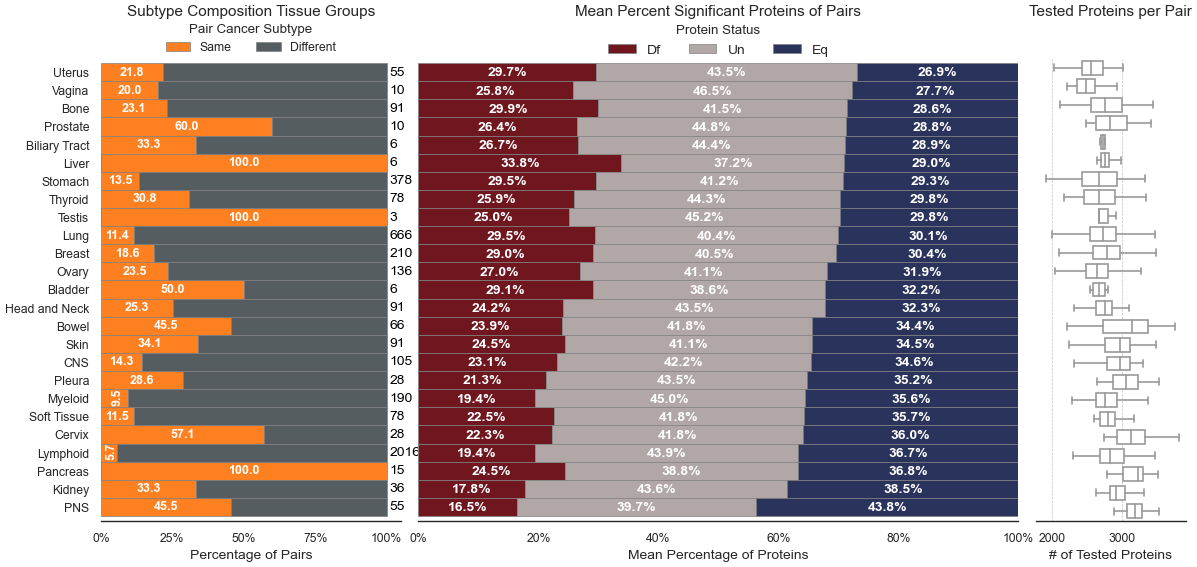

In [13]:
# Create a combined figure with 3 subplots (2,4,1 ratio)
# Share y and only keep the most left y-axis
# Includes:
# A - tissue group composition 
# B - mean percent significant proteins 
# C - number of tested proteins
# Set the figure size
fig = plt.figure(figsize=(14, 6))
# Set the width ratios for the subplots
gs = fig.add_gridspec(1, 3, width_ratios=[2, 4, 1], wspace=0.05)
# Figure 3A - Tissue Group Composition (Same or Different Cancer Subtype Pairs)
ax1 = fig.add_subplot(gs[0])
# Plot the main body for 3A
fig3A_data.plot.barh(
    stacked=True,
    width=1,
    ax=ax1,
    color={
        "Same": def_colors[3],
        "Different": def_colors[2]
    },
    edgecolor="gray",
    linewidth=0.5
)

# Add the percentage labels to center of the bars
for i, v in enumerate(fig3A_data["Same"]):
    # If v is 0, skip
    if v == 0:
        continue
    # If v is very small, rotate the text
    elif v < 10:
        ax1.text(
            (v / 2) + 1,   # x-position
            i + 0.1,       # y-position
            str(round(v, 1)),
            color="white",
            fontweight='bold',
            fontsize=9,
            ha="center",
            va="center",
            rotation=90
        )
    else:
        ax1.text(
            v / 2,   # x-position
            i,       # y-position
            str(round(v, 1)),
            color="white",
            fontweight='bold',
            fontsize=9,
            ha="center",
            va="center"
        )


ax1.set_xlabel(
    "Percentage of Pairs", size=10
)
ax1.set_ylabel("")
# X-ticks to percentage
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
# Show 0-25-50-75-100
ax1.xaxis.set_major_locator(mtick.MultipleLocator(25))
ax1.set_title(
    "Subtype Composition Tissue Groups",
    size=11,
    y=1.075
)

# Add number of totals to each y-axis at the end of the bar
for i, v in enumerate(pair_totals):
    ax1.text(
        101,
        i,
        str(v),
        color="black",
        # fontweight='bold',
        fontsize=10,
        va="center", 
    )

ax1.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
    ncol=3,
    # title="",
    fancybox=0,
    shadow=0,
    frameon=0,
    title="Pair Cancer Subtype"
)

# Figure 3B - 
ax2 = fig.add_subplot(gs[1])
# Create the stacked bar plot using pandas
fig3B_data.plot(
    kind='barh', 
    stacked=True, 
    width=1, 
    ax=ax2,
    edgecolor="gray",
    linewidth=0.5,
    # alpha=0.8,
    color={
        "Df": status_colors["Different"],
        "Un": status_colors["Unexplained"],
        "Eq": status_colors["Equivalent"]    
    }
)

# Create percentage labels
bar_values = fig3B_data.values.flatten('F')
for i,p in enumerate(ax2.patches):
    if bar_values[i] > 0.3:
        ax2.annotate(
            "{:.1f}%".format(bar_values[i]), 
            xy=(p.get_x()+ bar_values[i]/2, p.get_y()+0.45), 
            ha='center', va='center', 
            weight='bold', 
            fontsize=10, 
            color='white'
        )

# Set axis and title labels
ax2.set_xlim(0, 100)
ax2.set_xlabel(
    'Mean Percentage of Proteins', size=10
)
ax2.xaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_ylabel("")
ax2.set_yticklabels("")
ax2.set_yticks([])
ax2.set_title(
    "Mean Percent Significant Proteins of Pairs",
    size=11,
    y=1.075
)
# Set legend on top of the plot with 3 columns
ax2.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
    ncol=3,
    title="Protein Status",
    fancybox=0,
    shadow=0,
    frameon=0,
    fontsize=10,
)

# Figure 3C -
ax3 = fig.add_subplot(gs[2])

sns.boxplot(
    x="tested",
    y="Tissue",
    data=same_tissue_status_data,
    color="white",
    fliersize=0,
    order=eqOrder[::-1], 
    width=0.75,
    ax=ax3, 
)
ax3.set_xlabel(
    "# of Tested Proteins", 
    size=10
)
ax3.set_ylabel("")
ax3.set_yticklabels("")
ax3.set_yticks([])
ax3.set_title(
    "Tested Proteins per Pair",
    size=11,
    y=1.075
)

# Add grid to the plot
ax3.grid(
    axis='both', 
    color='gray', 
    linestyle='--', 
    linewidth=0.5, 
    alpha=0.5
)

sns.despine(
    left=True
)
plt.tight_layout()

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "high_summary_of_within_tissue_groupings",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

This composite figure provides a very high-level look at the average similarity of cancer cell line pairs within same tissue groupings, as well as highlights the values related to high or low similarity score. For instance pancreas tissue with 15 pairs that all coming from same tissue having high similarity makes sense and an expected behaviour, as well as it has one of the lowest percentage of unexplained protein percentages makes sense. However liver and testis both have lower pairs than say lymphoid tissue while their 6 and 3 pairs, respectively, originate from same subtype, still didn't make them more similar, which is quite interesting. 

The high similarity same-tissue groupings have higher number of tested proteins than when I look at the low similarity tissues.

While this figure provides a very high-level look at the similarity between same-tissue groupings, it only shows the average of all the pairs within same-tissue groupings, alternatively we can plot the individual protein status percentages of each pair in a boxplot of within same-tissue groupings.


### Equivalence Percent Boxplot

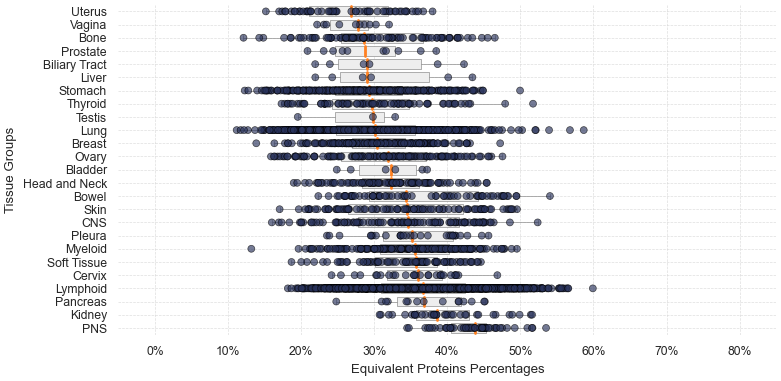

In [14]:
# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(8, 4),
    # sharex=False,
    # sharey=False,
)

# Build the boxplot
sns.boxplot(
    ax=ax,
    x="%Eq",
    y="Tissue",
    data=same_tissue_status_data,
    color=def_colors[4],
    fliersize=0,
    width=0.75,
    linewidth=.5,
    order=eqOrder[::-1],
    medianprops={
        "color": def_colors[3],
        "linewidth": 2,
        "linestyle": "-",
    },
)

# Add the scatterplot
sns.stripplot(
    ax=ax,
    x="%Eq",
    y="Tissue",
    data=same_tissue_status_data,
    color=def_colors[0],
    alpha=0.65,  
    order=eqOrder[::-1],
    size=5,
    jitter=0,
    linewidth=0.5,
    edgecolor="black",
    zorder=10,
    rasterized=True,
)

# Set the x-axis
ax.set_xlim(-5, 85)
# Set the x-axis ticks 10 to 80 by 10
ax.set_xticks(
    [x for x in range(0, 90, 10)]
)
# Set the x-axis ticks labels 10% to 80% by 10
ax.set_xticklabels(
    [f"{x}%" for x in range(0, 90, 10)],
    # fontsize=12,
    # fontweight="bold",
    # color="black",
)

# set grids on x and y
ax.grid(
    axis="both",
    color="lightgray",
    linestyle='--',
    linewidth=0.5,
    alpha=0.75
)

# Set the x-axis label
ax.set_xlabel(
    "Equivalent Proteins Percentages",
    # fontsize=12,
    # fontweight="bold",
    # color="black",
)
# Set the y-axis label
ax.set_ylabel(
    "Tissue Groups",
    # fontsize=12,
    # fontweight="bold",
    # color="black",
)


sns.despine(
    ax=ax,
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "TissueGroups_EqPercent_Boxplot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

In here we can see the distribution of the equivalence percent of each pair within same-tissue groupings. The boxplot shows the median, 25th and 75th percentiles, and the whiskers show the 1.5xIQR. And individual points are overlaid on top of the boxplot, which shows the distribution of the data.

### Difference Percent Boxplot

This one is the same as the previous figure, but this time I'm plotting the difference percent of each pair within same-tissue groupings. The boxplot shows the median, 25th and 75th percentiles, and the whiskers show the 1.5xIQR. And individual points are overlaid on top of the boxplot, which shows the distribution of the data.

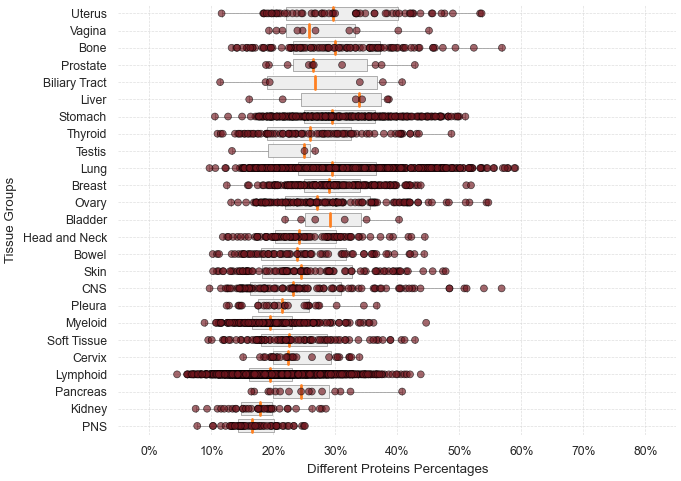

In [15]:
# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(7, 5),
    # sharex=False,
    # sharey=False,
)

# Build the boxplot
sns.boxplot(
    ax=ax,
    x="%Df",
    y="Tissue",
    data=same_tissue_status_data,
    color=def_colors[4],
    fliersize=0,
    width=0.75,
    linewidth=.5,
    order=eqOrder[::-1],
    medianprops={
        "color": def_colors[3],
        "linewidth": 2,
        "linestyle": "-",
    },
)

# Add the scatterplot
sns.stripplot(
    ax=ax,
    x="%Df",
    y="Tissue",
    data=same_tissue_status_data,
    color=def_colors[-2],
    alpha=0.65,  
    order=eqOrder[::-1],
    size=5,
    jitter=0,
    linewidth=0.5,
    edgecolor="black",
    zorder=10,
    rasterized=True,
)

# Set the x-axis
ax.set_xlim(-5, 85)
# Set the x-axis ticks 10 to 80 by 10
ax.set_xticks(
    [x for x in range(0, 90, 10)]
)
# Set the x-axis ticks labels 10% to 80% by 10
ax.set_xticklabels(
    [f"{x}%" for x in range(0, 90, 10)],
    # fontsize=12,
    # fontweight="bold",
    # color="black",
)

# set grids on x and y
ax.grid(
    axis="both",
    color="lightgray",
    linestyle='--',
    linewidth=0.5,
    alpha=0.75
)

# Set the x-axis label
ax.set_xlabel(
    "Different Proteins Percentages",
    # fontsize=12,
    # fontweight="bold",
    # color="black",
)
# Set the y-axis label
ax.set_ylabel(
    "Tissue Groups",
    # fontsize=12,
    # fontweight="bold",
    # color="black",
)

sns.despine(
    ax=ax,
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "TissueGroups_DfPercent_Boxplot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

# Protein Specific Look at Same-Tissue Groupings

## Identifying Most Quantitatively Stable and Variable Proteins

Within the same-tissue groupings I will create a protein specific summary table that contains the information about the protein; how many pairs it is tested in, how many pairs it is equivalent, how many pairs it is different, and the RSM score. Using the `%tested` and `%(EQ-DF)` (RSM) columns, then I can identify the quantitatively stable and variable proteins that fit my criteria. The criteria I will use is the same as the previous notebook, where I will use the following criteria to identify the quantitatively stable and variable proteins:

- **Quantitatively Stable Proteins:** Proteins that are tested in at least 95% of the cell line pairs and its RSM score is more than 35.
- **Quantitatively Variable Proteins:** Proteins that are tested in at least 95% of the cell line pairs and its RSM score is less than -35.

> **Note 1:** The RSM (Relative Stability Metric) score is calculated as the difference between the percentage of cell line pairs where the protein is identified as equivalent and the percentage of cell line pairs where the protein is identified as different. The RSM score establishes the tendency of a given protein to be stable or variable for all or subset of the comparisons.

> **Note 2:** The 95% testing threshold is used to make sure that the protein is tested in majority of the cell line pairs and not just a few to establish. Since a protein can be tested in one and being equivalent or different doesn't make it stable or variable for all or subset of comparisons.

In [16]:
# Find Mostly Variable and Mostly Stable Proteins
# Criterias when selecting proteins
stability_cutoff = 35
tested_cutoff = 95
variability_cutoff = -35
print(f"Protein must be tested at least {tested_cutoff}% of comparisons per tissue group.")
print("For stability, RSM >=", stability_cutoff)
print("For variability, RSM <=", variability_cutoff)

Protein must be tested at least 95% of comparisons per tissue group.
For stability, RSM >= 35
For variability, RSM <= -35


### Calculate Protein Specific Summary for Tissue Groupings

In the previous notebook, I've used the shared summary table that calculated the protein-specific information across all the pairs, but here I am interested in the protein-specific information within same-tissue groupings. So I will create a protein specific summary table for each same-tissue groupings using protein status matrix table that I've opened in the beginning of the notebook.

The resulting table wil be save in the `data/results/{notebook_name}/` folder as `tissue_grouped_relative_stability_data.feather` file. As well as a csv version for supplementary data.

In [17]:
# Create Counts of Pairs per Tissue (S1 vs S2)

# Number of Equivalent Counts
eq_cnts = (protStatusDF.select(
    pl.exclude(["S1", "S2"])
)  == 1.0).groupby(
    info["Tissue_type_S1"], 
    info["Tissue_type_S2"]
).sum().fill_null(0).sort(
    ["Tissue_type_S1", "Tissue_type_S2"]
)
# Number of Different Counts
df_cnts = (protStatusDF.select(
    pl.exclude(["S1", "S2"])
)  == -1.0).groupby(
    info["Tissue_type_S1"], 
    info["Tissue_type_S2"]
).sum().fill_null(0).sort(
    ["Tissue_type_S1", "Tissue_type_S2"]
)

ux_cnts = (protStatusDF.select(
    pl.exclude(["S1", "S2"])
)  == 0.0).groupby(
    info["Tissue_type_S1"], 
    info["Tissue_type_S2"]
).sum().fill_null(0).sort(
    ["Tissue_type_S1", "Tissue_type_S2"]
)

# Number of pairs per given group
pr_cnts = protStatusDF.groupby([
    info["Tissue_type_S1"], 
    info["Tissue_type_S2"]]
).count().sort(
    ["Tissue_type_S1", "Tissue_type_S2"]
)

# Get the tested percentages of pairs
grouped_Tested_data = pl.concat(
    [
        ux_cnts.select(
            ["Tissue_type_S1", "Tissue_type_S2"]
        ),
        (
            ux_cnts.select(
                pl.exclude(["Tissue_type_S1", "Tissue_type_S2"])
            ) + 
            eq_cnts.select(
                pl.exclude(["Tissue_type_S1", "Tissue_type_S2"])
            ) +
            df_cnts.select(
                pl.exclude(["Tissue_type_S1", "Tissue_type_S2"])
            )
        ) / 
        pr_cnts["count"]
    ],
    how='horizontal'
)

# Get the percentage of equivalent and different pairs
# Equivalent
grouped_EQ_data = pl.concat(
    [
        # Keep the tissue-tissue combination columns
        eq_cnts.select(
            ["Tissue_type_S1", "Tissue_type_S2"]
        ),
        # Calculate the percentage of equivalent pairs
        (
            eq_cnts.select(
                pl.exclude(["Tissue_type_S1", "Tissue_type_S2"])
            ) / pr_cnts["count"]
        ) * 100
    ] ,
    how='horizontal'
)

# Different
grouped_DF_data = pl.concat(
    [
        # Keep the tissue-tissue combination columns
        df_cnts.select(
            ["Tissue_type_S1", "Tissue_type_S2"]
        ),
        # Calculate the percentage of different pairs
        (
            df_cnts.select(
                pl.exclude(["Tissue_type_S1", "Tissue_type_S2"])
            ) / pr_cnts["count"]
        ) * 100
    ] ,
    how='horizontal'
)

# Make sure the columns are the same
if grouped_EQ_data.columns == grouped_DF_data.columns:
    # Calculate EQ% - DF% for each tissue-tissue combination
    eq_df_arr = (
        (
            (
                grouped_EQ_data.select(
                    pl.exclude(["Tissue_type_S1", "Tissue_type_S2"])
                )
            ) - 
            (
                grouped_DF_data.select(
                    pl.exclude(["Tissue_type_S1", "Tissue_type_S2"])
                )
            )
        ) * 
        (
            grouped_Tested_data.select(
                pl.exclude(["Tissue_type_S1", "Tissue_type_S2"])
            )
        )
    ).to_pandas().fillna(0)

    # Add the tissue-tissue combination columns
    eq_df_arr = pd.DataFrame(
        eq_df_arr, 
        columns=grouped_EQ_data.columns[2:]
    )

    # Add the tissue-tissue combination columns
    eq_df_arr = pd.concat(
        [
            grouped_DF_data.select(
                ["Tissue_type_S1", "Tissue_type_S2"]
            ).to_pandas(),
            eq_df_arr
        ], 
        axis=1
    ).set_index(
        ["Tissue_type_S1", "Tissue_type_S2"]
    ).T
    # Save the data
    feather.write_dataframe(
        eq_df_arr,
        output_path + "tissue_grouped_relative_stability_data.feather",
    )
    
else:
    raise ValueError(
        "The columns of the dataframes are not the same."
    )

print("Data Shape:", eq_df_arr.shape)
eq_df_arr.head().iloc[:, :5]

Data Shape: (7975, 325)


Tissue_type_S1 Biliary Tract                                  
Tissue_type_S2 Biliary Tract  Bladder    Bone    Bowel     CNS
Q9Y651                0.0000   0.0000  0.0000   0.0000  0.0000
P37108               33.3333 -18.7500 14.2857   8.3333 48.3333
Q96JP5                8.3333  14.0625 13.3929  24.3490 11.0000
Q9Y4H2                0.0000   0.0000  0.0000   0.0000  0.0000
P36578               50.0000  37.5000 10.7143 -18.7500  3.3333

The resulting table contains multi-column where first level is tissue of S1 and second level is tissue of S2. Each row is a protein and the values are the RSM score calculated for that protein within that same-tissue grouping.

## Calculate a Binary Table for Same-Tissue Groupings

Since there are many groupings and proteins to look at I opted to create a binary table that contains the protein as a row and the same-tissue grouping as the column and if the protein is quantitative stable or variable in that same-tissue grouping then it will be 1, otherwise 0. This will make it easier to look at the protein specific information within same-tissue groupings.

### Stable Protein Binary Table

Here I will create the binary table for the quantitatively stable proteins within same-tissue groupings. The resulting table wil be save in the `data/results/{notebook_name}/` folder as `same_tissue_stability_binary_table.feather` file. As well as a csv version for supplementary data.

If no protein is quantitatively stable in a same-tissue grouping then the column will be dropped from the table.

In [18]:
# Create a mostly stable dataframe (EQ% - DF% >= stbCut) (Mostly Stable)
mostly_stable = (eq_df_arr >= stability_cutoff).T.reset_index()
mostly_stable = mostly_stable[
    mostly_stable["Tissue_type_S1"] == mostly_stable["Tissue_type_S2"]
]
mostly_stable.insert(
    0, 
    "Tissue", 
    mostly_stable["Tissue_type_S1"]
)
# Remove Tissue_type_S1 and Tissue_type_S2
mostly_stable = mostly_stable.drop(
    ["Tissue_type_S1", "Tissue_type_S2"],
    axis=1
).set_index("Tissue").T

# Drop proteins that are not mostly stable in any tissue
mostly_stable = mostly_stable[mostly_stable.sum(axis=1) != 0]

# Save the data
feather.write_dataframe(
    mostly_stable,
    f"{output_path}same_tissue_stability_binary_table.feather",
)

# save the data to table_s2_8
mostly_stable.to_csv(
    f"{supp_path}table_s2_8.csv"
)

print("Data Shape:", mostly_stable.shape)
mostly_stable.head()

Data Shape: (2311, 25)


Tissue  Biliary Tract  Bladder   Bone  Bowel  Breast    CNS  Cervix  \
P37108          False    False  False   True   False   True    True   
Q96JP5          False    False  False   True   False  False   False   
P36578           True     True  False  False   False  False    True   
Q6SPF0          False    False  False  False   False  False   False   
O76031           True     True   True   True    True   True    True   

Tissue  Head and Neck  Kidney  Liver   Lung  Lymphoid  Myeloid  Ovary    PNS  \
P37108           True    True  False  False     False     True   True   True   
Q96JP5          False   False  False  False     False    False  False   True   
P36578          False    True   True  False     False     True  False  False   
Q6SPF0          False   False  False  False     False    False  False   True   
O76031           True   False  False   True      True     True  False   True   

Tissue  Pancreas  Pleura  Prostate   Skin  Soft Tissue  Stomach  Testis  \
P37108      True    True      True  False         True    False   False   
Q96JP5      True    True     False  False        False    False   False   
P36578      True   False     False   True         True    False   False   
Q6SPF0     False   False     False  False        False    False   False   
O76031     False    True     False   True         True     True   False   

Tissue  Thyroid  Uterus  Vagina  
P37108     True   False    True  
Q96JP5    False   False   False  
P36578    False   False   False  
Q6SPF0    False   False   False  
O76031    False   False   False

There are 2311 proteins that are quantitatively stable in at least one of the same-tissue groupings. 

### Variable Protein Binary Table

Here I will create the binary table for the quantitatively variable proteins within same-tissue groupings. The resulting table wil be save in the `data/results/{notebook_name}/` folder as `same_tissue_variable_binary_table.feather` file. As well as a csv version for supplementary data.

In [19]:
# Create a mostly stable dataframe (EQ% - DF% <= varCut) (Mostly Variable)
mostly_variable = (eq_df_arr <= variability_cutoff).T.reset_index()
mostly_variable = mostly_variable[
    mostly_variable["Tissue_type_S1"] == mostly_variable["Tissue_type_S2"]
]
mostly_variable.insert(
    0, 
    "Tissue", 
    mostly_variable["Tissue_type_S1"]
)
# Remove Tissue_type_S1 and Tissue_type_S2
mostly_variable = mostly_variable.drop(
    ["Tissue_type_S1", "Tissue_type_S2"],
    axis=1
).set_index("Tissue").T

# Drop proteins that are not mostly variable in any tissue
mostly_variable = mostly_variable[mostly_variable.sum(axis=1) != 0]

# Save the data
feather.write_dataframe(
    mostly_variable,
    f"{output_path}same_tissue_variability_binary_table.feather",
)

# save the data to table_s2_9
mostly_variable.to_csv(
    f"{supp_path}table_s2_9.csv"
)

print("Data Shape:", mostly_variable.shape)
mostly_variable.head()

Data Shape: (1519, 25)


Tissue  Biliary Tract  Bladder   Bone  Bowel  Breast    CNS  Cervix  \
Q9P258           True    False  False  False   False  False   False   
P55036          False     True  False  False   False  False   False   
Q96D53           True    False  False  False   False  False   False   
P02786           True    False  False  False   False  False    True   
Q9Y490          False    False  False  False   False  False   False   

Tissue  Head and Neck  Kidney  Liver   Lung  Lymphoid  Myeloid  Ovary    PNS  \
Q9P258          False   False  False  False     False    False  False  False   
P55036          False   False  False  False     False    False  False  False   
Q96D53          False   False  False  False     False    False  False  False   
P02786          False   False  False  False     False    False  False  False   
Q9Y490          False   False  False  False     False    False  False  False   

Tissue  Pancreas  Pleura  Prostate   Skin  Soft Tissue  Stomach  Testis  \
Q9P258     False   False      True  False        False    False   False   
P55036     False   False     False  False        False    False   False   
Q96D53     False   False     False  False        False    False   False   
P02786     False    True     False  False         True    False   False   
Q9Y490     False   False      True  False        False    False   False   

Tissue  Thyroid  Uterus  Vagina  
Q9P258    False   False   False  
P55036    False   False   False  
Q96D53    False   False   False  
P02786    False   False   False  
Q9Y490     True   False    True

There are 1519 proteins that are quantitatively variable in at least one of the same-tissue groupings.

### Number of Quantitatively Stable and Variable Proteins per Same-Tissue Groupings 

Here I will take advantage of both binary tables and create a visualization that shows the number of proteins identified as stable and variable in each same-tissue groupings. I will also add the the number of proteins that are distinctly stable or variable in each same-tissue groupings, meaning they are not stable or variable in any other same-tissue groupings. They will be darker in color to highlight them, on a stacked bar plot.

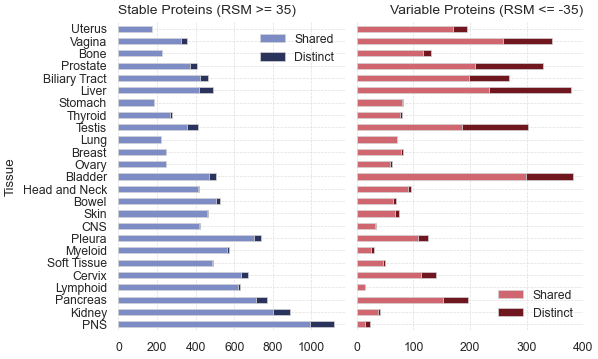

In [20]:
# Counts of distinct and shared proteins for mostly stable and mostly variable

# Stable
mostly_stable_cnts = mostly_stable.groupby(
    (mostly_stable.sum(axis=1) == 1).map({
        True: "Distinct",
        False: "Shared"
    })
).sum().T

# Variable
mostly_variable_cnts = mostly_variable.groupby(
    (mostly_variable.sum(axis=1) == 1).map({
        True: "Distinct",
        False: "Shared"
    })
).sum().T

pd.concat([
    mostly_stable_cnts.rename(
        columns={
            "Shared": "# of Stable-Shared",
            "Distinct": "# of Stable-Distinct"
        }
    ),
    mostly_variable_cnts.rename(
        columns={
            "Shared": "# of Variable-Shared",
            "Distinct": "# of Variable-Distinct"
        }
    )
],
axis=1
).loc[
    eqOrder
].to_csv(
    f"{supp_path}table4.csv"
)

# Plot 2 Column 1 Row Bar Figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(6, 4),
    sharey=True,
    gridspec_kw=dict(
        wspace=0.05,
        hspace=0.1
    ),   
)

# Plot the Barplot 1 (Mostly Stable)
mostly_stable_cnts.loc[
    eqOrder,
    [
        "Shared",
        "Distinct"
    ]
].plot.barh(
    stacked=True,
    ax=ax[0],
    edgecolor="lightgrey",
    linewidth=0.5,
    color=[
        def_colors[1],
        def_colors[0]        
    ]
)

ax[0].grid(
    axis="both",
    color="lightgray",
    linestyle='--',
    linewidth=0.5,
    alpha=0.75
)

ax[0].set_title(
    f"Stable Proteins (RSM >= {stability_cutoff})",
    loc="left",
    fontsize=10,
)

ax[0].legend(frameon=False)

# Plot the Barplot 2 (Mostly Variable)
mostly_variable_cnts.loc[
    eqOrder,
    [
        "Shared",
        "Distinct"
    ]
].plot.barh(
    stacked=True,
    ax=ax[1],
    edgecolor="lightgrey",
    linewidth=0.5,
    color=[
        def_colors[-1],
        def_colors[-2]
    ],
)

ax[1].set_title(
    f"Variable Proteins (RSM <= {variability_cutoff})",
    loc="right",
    fontsize=10,
)

# Add grid to the plot


ax[1].grid(
    axis="both",
    color="lightgray",
    linestyle='--',
    linewidth=0.5,
    alpha=0.75
)

ax[1].legend(frameon=False)

sns.despine(
    left=True,
    bottom=True,
)

plt.tight_layout()

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "Stable_Variable_Protein_Counts_Barplot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

The distinct annotated proteins are at a higher proportion in the variable proteins, which enforces the idea that the stable proteins are more conserved across same-tissue groupings than the variable proteins.

## Exploring the Stable Proteins within Same-Tissue Groupings

### Number of Tissue Groups Protein Identified as Stable

The first thing I want to check is how many same-tissue groupings each protein is identified as stable. I've already glimpsed at the individual tissue group with distinctly identified stable proteins, but this will give me an idea of how many same-tissue groupings are conserved for each protein.

In [21]:
annotated_data = pd.read_csv(f"{supp_path}table_s2_5.csv")
stable_in_all = annotated_data.loc[
    annotated_data["Annotation"]=="Stable",
    "entry"
].to_list()

tissueN = mostly_stable.shape[1]
plot_data = mostly_stable.sum(axis=1).sort_values(
    ascending=False
).to_frame().rename(
    columns={0: "Number of Tissue Group"}
)

plot_data["Percentage"] = plot_data["Number of Tissue Group"] / tissueN * 100

# Add the stable in all cell lines
plot_data["is_stable_in_all"] = plot_data.index.isin(stable_in_all)

print("Data Shape:", plot_data.shape)
plot_data.head()

Data Shape: (2311, 3)


Number of Tissue Group  Percentage  is_stable_in_all
P09012                      25    100.0000              True
P08579                      25    100.0000              True
P12270                      24     96.0000              True
P49792                      24     96.0000              True
Q9UQ35                      23     92.0000              True

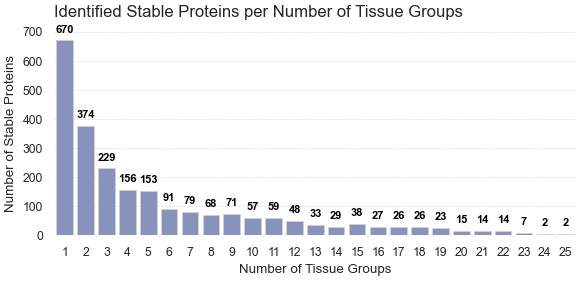

In [22]:
# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(6, 3),
    # sharey=True,
    # sharex=True,
)

sns.countplot(
    plot_data["Number of Tissue Group"],
    ax=ax,
    color=def_colors[1], 
    edgecolor="lightgrey",
    linewidth=0.5,
    # From 1 to 25
    order=range(1, tissueN + 1)
)

# Remove yaxis
ax.set_xlabel("Number of Tissue Groups")
ax.set_ylabel("Number of Stable Proteins")
ax.set_title(
    f"Identified Stable Proteins per Number of Tissue Groups",
    fontsize=12,
    loc="left",
    pad=10
)

# Add numbers on top of the bars
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".0f"),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 8),
        textcoords="offset points", 
        fontsize=8,
        fontweight="bold",
        color="black", 
        # rotation=90    
    )

# Grid
ax.grid(
    axis="y",
    color="lightgray",
    linestyle='--',
    linewidth=0.5,
    alpha=0.75
)

sns.despine(
    ax=ax,
    left=True,
    bottom=True,
)
plt.tight_layout()

if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "stableProteins_per_numberOfTissue_barplot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

In [23]:
print("Number of proteins stable in all cancer cell lines (previous notebook):", len(stable_in_all))
print("Difference of proteins found in stable in all but not in same-tissue:", len(set(stable_in_all) - set(mostly_stable.index)))
int_stable = set(stable_in_all).intersection(set(mostly_stable.index))

Number of proteins stable in all cancer cell lines (previous notebook): 171
Difference of proteins found in stable in all but not in same-tissue: 0


There are quite a bit of proteins tissue group specific as well as conserved across few tissue groups. On there are only 2 proteins that are identified as stable in all 25 tissue groups, however if we look at the proteins that are identified as stable in at least 20 tissue groups, hat number increaes to 54. Which means the proteins identified in the previous notebook to be stable in all cancer cell lines have some tissues that they are not stable in.

However all the proteins that are identified as stable in all cancer cell lines are also identified as stable in all the same-tissue groupings, which is reassuring.

### Comparison of the Stable Proteins within Same-Tissue Groupings

Here I will expand on the detailed look at where the stable proteins are identified as stable and how many of them are identified as stable in each same-tissue groupings. I will create a heatmap that shows the stable proteins in each same-tissue groupings. The heatmap will be based on a binary table where the protein is identified as stable in that same-tissue grouping then it will be 1 (dark blue), otherwise 0 (white). I will create a column coloring based on if the protein is found in stable in all cancer cell lines (stable-core), then it will be colored in purple, otherwise it will be colored in beige. I will also add a bar plot for the row values that calculates the number of stable-core proteins in each same-tissue groupings overall. Finally I will cut the hierarchical clustering tree to two clusters in both column and rows to create two clusters to explore.

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 15.107333333333337 mm


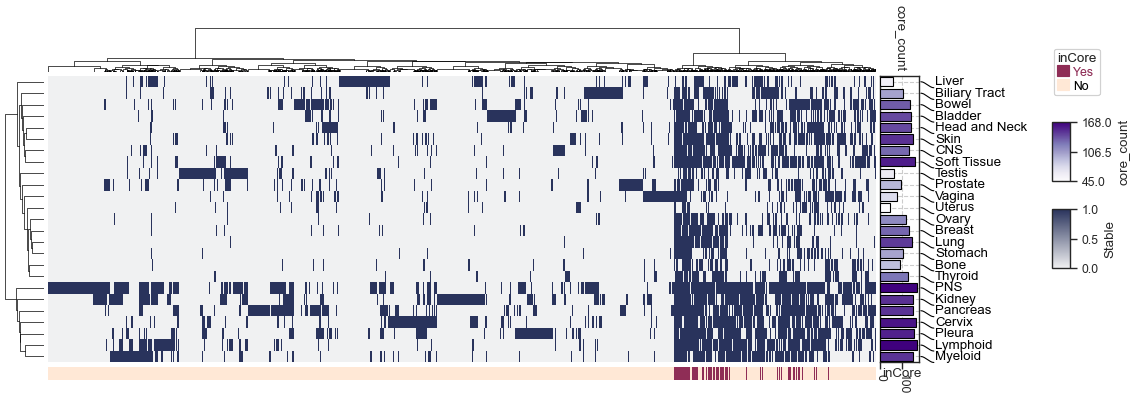

In [24]:
# Initialize the data to be plotted
plot_data = mostly_stable.T#.astype(int).T#.replace(0, 0.01)

count_data = pd.concat(   
    [
        (plot_data == 1).sum(axis=1), 
        ((plot_data.loc[:, plot_data.columns.isin(int_stable)] == 1)).sum(axis=1)
    ], axis=1
)
count_data.columns = [
    "Stable Count",
    "Stable in Core Count"
]

# Create the Clustermap (PyComplexHeatmap)
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(12, 4),
)

col_ha = pch.HeatmapAnnotation(
    inCore=pch.anno_simple(
        mostly_stable.index.to_frame()[0].isin(
            int_stable
        ).to_frame().rename(
            columns={0:'Stable in All Samples?'}
        ).replace(
            {True: 'Yes', False: 'No'}
        ),
        colors={
            "Yes": "#8f2d56",
            "No": "#ffe8d6"
        }
    ),
    axis=1
)

row_ha = pch.HeatmapAnnotation(
    core_count = pch.anno_barplot(
        count_data["Stable in Core Count"],
        cmap="Purples",
    ),
    tissue_labels = pch.anno_label(
        plot_data.index.to_frame(),
        colors='black'
    ),
    axis=0,
)

res = pch.ClusterMapPlotter(
    data=plot_data,

    cmap = sns.light_palette(def_colors[0], as_cmap=True),
    vmin=0,
    vmax=1,
    # Row 
    row_cluster=True,
    row_cluster_method="ward",
    row_cluster_metric="euclidean",
    show_rownames=True,
    row_names_side='right',
    # row_split=2,
    # row_split_gap=1,
    row_dendrogram=True,
    # Column
    col_cluster=True,
    col_cluster_method="ward",
    col_cluster_metric="euclidean",
    show_colnames=False,
    # col_split=2,
    # col_split_gap=1,
    col_dendrogram=True,
    
    label="Stable",
    # tree_kws={
    #     'row_cmap': 'Dark2',
    #     'col_cmap': 'Dark2',
    # }, 
    bottom_annotation=col_ha,
    right_annotation=row_ha,
    rasterized=True,
)

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "SameTissue_Identification_Clustermap",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

The second same-tissue grouping (row) cluster is the high-similarity groupings, that captures most of the stable-core proteins. The first same-tissue grouping (row) cluster is the rest, some do capture a lot of stable-core proteins such as Soft-tissue with around 160 stable-core proteins, but most of them capture less than 100 stable-core proteins.

When it comes to the column clusters, the first cluters (the large one) doesn't have any stable-core proteins, where it is mostly represents the tissue-enriched or tissue-specific stable proteins. The second cluster (the small one) is the one that captures the stable-core proteins, which is the high-similarity same-tissue groupings, where most of the tissue-groups are able to capture them.

This provides a look at tissue-enriched stable proteins as well as the stable-core proteins within same-tissue groupings, where I will be exploring these stable proteins with enrichment analysis in the next section.

## Exploring the Variable Proteins within Same-Tissue Groupings

### Number of Tissue Groups Protein Identified as Variable

The first thing I want to check is how many same-tissue groupings each protein is identified as variable. I've already glimpsed at the individual tissue group with distinctly identified variable proteins, but this will give me an idea of how many same-tissue groupings are conserved for each protein.

In [25]:
variable_in_all = annotated_data.loc[
    annotated_data["Annotation"]=="Variable",
    "entry"
].to_list()
tissueN = mostly_variable.shape[1]

plot_data = mostly_variable.sum(axis=1).sort_values(
    ascending=False
).to_frame().rename(
    columns={0: "Number of Tissue Group"}
)
plot_data["Percentage"] = plot_data["Number of Tissue Group"] / tissueN * 100

# Add the stable in all cell lines
plot_data["is_stable_in_all"] = plot_data.index.isin(stable_in_all)
# Add the variable in all cell lines
plot_data["is_variable_in_all"] = plot_data.index.isin(variable_in_all)

print("Data Shape:", plot_data.shape)
plot_data.head()

Data Shape: (1519, 4)


Number of Tissue Group  Percentage  is_stable_in_all  \
P04080                      16     64.0000             False   
P49006                      15     60.0000             False   
P07858                      15     60.0000             False   
P04439                      14     56.0000             False   
P08670                      14     56.0000             False   

        is_variable_in_all  
P04080                True  
P49006               False  
P07858               False  
P04439               False  
P08670               False

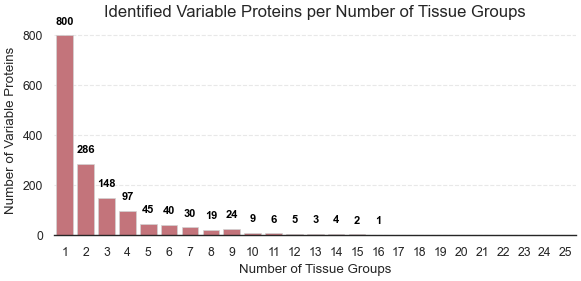

In [26]:
# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(6, 3),
    # sharey=True,
    # sharex=True,
)

sns.countplot(
    plot_data["Number of Tissue Group"],
    ax=ax,
    color=def_colors[-1], 
    edgecolor="lightgrey",
    linewidth=0.5,
    # From 1 to 25
    order=range(1, tissueN + 1)
)

# Remove yaxis
ax.set_xlabel("Number of Tissue Groups")
ax.set_ylabel("Number of Variable Proteins")
ax.set_title(
    f"Identified Variable Proteins per Number of Tissue Groups",
    fontsize=12,
)

# Add numbers on top of the bars
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".0f"),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points", 
        fontsize=8,
        fontweight="bold",
        color="black", 
        # rotation=90    
    )

# y-grid lines
ax.grid(
    axis='y', 
    linestyle='--', 
    alpha=0.5,
    color="lightgrey"
)

sns.despine(
    ax=ax,
    left=True
)
plt.tight_layout()

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "variableProteins_per_numberOfTissue_barplot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

In [27]:
print("Is there any protein stable in all cancer cell lines:", plot_data["is_stable_in_all"].sum())
print("Is there any protein variable in all cancer cell lines:", plot_data["is_variable_in_all"].sum())

print("Number of proteins variable in all cancer cell lines (previous notebook):", len(variable_in_all))
print("Difference of proteins found in variable in all but not in same-tissue:", len(set(variable_in_all) - set(mostly_variable.index)))
int_stable = set(variable_in_all).intersection(set(mostly_variable.index))

Is there any protein stable in all cancer cell lines: 12
Is there any protein variable in all cancer cell lines: 26
Number of proteins variable in all cancer cell lines (previous notebook): 26
Difference of proteins found in variable in all but not in same-tissue: 0


Looking at the number of same-tissue groupings that each protein is identified as variable highest number of tissue a protein is identified as variable is 16. Quite an interesting thing is that I realized from 1519 total variable proteins identified across all same-tissue groupings, 12 of them are identified as stable core proteome in the previous notebook. And all of the variable prtein identified in the previous notebook are also identified as variable in all the same-tissue groupings, which is reassuring.

Another pattern that aligns wth my intial expectation is that proteins identified as variable do have more distinctness between same-tissue groupings than the stable proteins. While for stable too there were more proteins distinct (n=1) or few (n<5) it had sizeable number of proteins in more tissue groups n>10, but for variable proteins majority of the proteins are distinct to (n=1) or find in few (n<5) tissue groups.

Next stop is to look at the stable protein's enrichment results.

# Enrichment Analysis with g:Profiler

The g:Profiler's api is the main toolset I've used to run the protein sets identified using `questvar`. The api is very easy to use and provides a lot of options to customize the enrichment analysis. 

## Quantitatively Stable Proteins

First I've run the set that I am most interested in, the quantitatively stable proteins. Here is the description of the variables I've used to run the api.

- `m_pval` - The p-value threshold used to get the results from the api, used 1 to get all terms if at least one protein is found in the term
- `e_pval` - The p-value threshold to filter and identified significantly enriched terms, used 0.05
- `correction` - The multiple testing correction method used to correct the p-values, used `fdr`.
- `pval_cap` - This is the value to cap the p-values in some plotting functions. Used 10**-15 to replace smaller p-values.
- `organism` - The organism used to run the enrichment analysis, used `hsapiens`.
- `sources` - The databases used to run the enrichment analysis, used `GO:BP`, `GO:CC`, `GO:MF`, `KEGG`, `REACTOME`.
- `background` - The list of proteins used as background for the enrichment analysis, used all proteins in the dataset.
- `enrichment_sets` - A dictionary with sets of proteins to run the key is the name of the set and the value is the list of proteins in the set.

Here is the printout of the parameters used as well as some other information about the api run.

Enrichment analysis parameters:
  - match p-value threshold: 1
  - enrichment p-value threshold: 0.05
  - correction method: fdr
  - capping p-value at: 1e-15
  - using hsapiens as organism
  - getting results from ['GO:BP', 'GO:CC', 'GO:MF', 'KEGG', 'REAC'] 
  - using 7975 proteins as custom background
  - running multi-query enrichment with 25 queries
      - using 462 proteins for 'Biliary Tract' enrichment analysis
      - using 505 proteins for 'Bladder' enrichment analysis
      - using 227 proteins for 'Bone' enrichment analysis
      - using 524 proteins for 'Bowel' enrichment analysis
      - using 245 proteins for 'Breast' enrichment analysis
      - using 421 proteins for 'CNS' enrichment analysis
      - using 674 proteins for 'Cervix' enrichment analysis
      - using 417 proteins for 'Head and Neck' enrichment analysis
      - using 890 proteins for 'Kidney' enrichment analysis
      - using 492 proteins for 'Liver' enrichment analysis
      - using 222 proteins for 'Lung

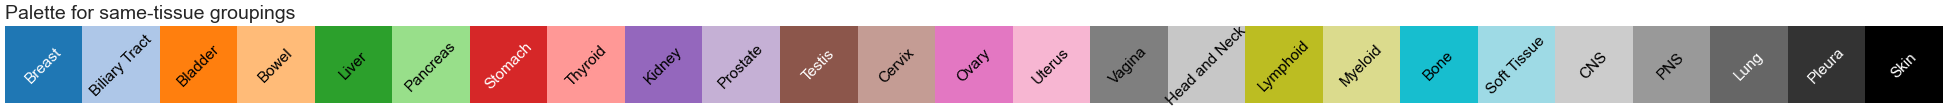

In [28]:
# Variables for the enrichment setup
m_pval = 1 
e_pval = 0.05 
correction = 'fdr'
pval_cap = 10**-15 
organism = "hsapiens"
sources = ["GO:BP", "GO:CC", "GO:MF", "KEGG", "REAC"]
background = allProteins.tolist()

# Create {Tissue: [proteins]} dictionary for enrichment
enrichment_sets = mostly_stable.apply(
    lambda x: x[x == True].index.tolist()
).to_dict()

# Create a palette for the tissues (n=25)
cust_pal = sns.color_palette(
    "tab20", 
    metadata["Tissue_type"].unique().shape[0]
) 
# Create a dictionary of the systen types and colors (replace the last color with blackish)
tissue_labels = dict(
    zip(
        metadata["Tissue_type"].unique(), 
        list(cust_pal.as_hex())[:-5]+
        [
            "#CCCCCC",  # Light Gray
            "#999999",  # Medium Gray
            "#666666",  # Dark Gray
            "#333333",  # Even Darker Gray
            "#000000"   # Black
        ] 
    )
)

queries = list(tissue_labels.keys())

analysis_name = "gProf_pval{}_TissueComparison".format(e_pval)

enrich.printParams(
    m_pval,
    e_pval,
    correction,
    pval_cap,
    organism,
    sources,
    background,
    enrichment_sets,
    analysis_name
)

plots.color_palette(
    tissue_labels,
    name = "same-tissue groupings"
)

With those parameters I've run the api and saved the results in the `data/results/{notebook_name}/` folder. The full set of terms are saved as `gProf_TissueComparison_FullList.csv`, which includes non-significantly enriched terms for reference and a subseted version is saved also.

### Running the Enrichment Analysis

In [29]:
# Run and Save the Enrichment Analysis
# enrich.run_gprofiler(
#     query = enrichment_sets,
#     background = background,
#     organism = organism,
#     user_threshold = m_pval,
#     signf_threshold = e_pval,
#     correction = correction,
#     sources = sources,
#     pval_cap = pval_cap,
#     no_evidences = False,
#     no_iea = False,
#     ordered = False,
#     simplify_cols=False,
#     save_path = output_path,
#     analysis_name = "gProf_TissueComparison_FullList",
#     verbose = True
# )

print()

# Read the results
gp_res = pd.read_csv(
    f"{output_path}gProf_TissueComparison_FullList.csv",
    sep=","
)

# Create a subset of the results with the p-value cutoff
subset_gp_res = gp_res[
    gp_res["p_value"] < e_pval
]

# Save the subset results
subset_gp_res.to_csv(
    f"{output_path}{analysis_name}.csv",
    sep=",",
    index=False
)

print(f"""After the p-value cutoff of {e_pval} there are total of {subset_gp_res.shape[0]} enriched terms.""")

utils.print_series(
    subset_gp_res["query"].value_counts(),
    header = f"Number of enriched terms per query with p-val cutoff {e_pval}:",
    tab = 2,
    elements_with_order = queries
)

After the p-value cutoff of 0.05 there are total of 16919 enriched terms.
Number of enriched terms per query with p-val cutoff 0.05:
   Breast -> 570
   Biliary Tract -> 561
   Bladder -> 515
   Bowel -> 566
   Liver -> 799
   Pancreas -> 834
   Stomach -> 366
   Thyroid -> 525
   Kidney -> 900
   Prostate -> 475
   Testis -> 289
   Cervix -> 902
   Ovary -> 644
   Uterus -> 338
   Vagina -> 490
   Head and Neck -> 801
   Lymphoid -> 981
   Myeloid -> 949
   Bone -> 494
   Soft Tissue -> 745
   CNS -> 869
   PNS -> 1206
   Lung -> 596
   Pleura -> 829
   Skin -> 675


I've created small data visualizations to summarize the enrichment results from a very high-level overview to a more detailed source specific overviews. Here I will be going over some of them to highlight and talk about the results we observe from the set of stable proteins' enrichment analysis.

### Summary of the Enrichment Results

#### The P-value and Enrichment Score Distributions

In this plot I create two or more subplots to highlight the distributions of two important values from the enrichment analysis. The p-value and the enrichment score. The p-value is the statistical significance of the enrichment of the term, while the enrichment score is the combined score of the term based on the p-value and the number of proteins in the term. 

There are two enrichment score calculations available in this framework:
- Gene Ratio: The ratio of the number of proteins in the set that found in the terms to the number of proteins in the term 
    - This is the default method used in the framework
    - gene_ratio = (n_in_set / n_in_term)
- Enrichment: similar to gene ratio with adjusted to the background and total number of proteins in the set
    - enrichment = (n_in_set / n_in_term) / (n_in_background / n_total)
    
Within the plot I plot p-value, gene ratio and enrichment values with the 90th, 95th, and 99th percentiles highlighted with vertical lines. 

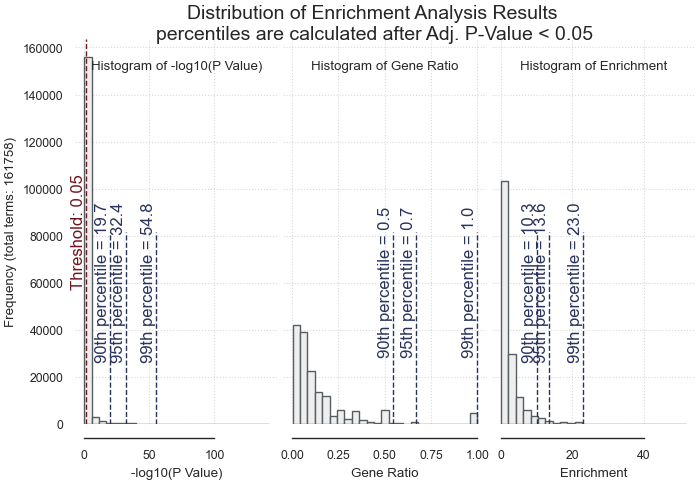

In [30]:
plots.enrich_distribution(
    data = gp_res, # The main data to plot
    subset_col = "p_value",
    subset_thr = e_pval,
    plot_cols = ["-log10(p_value)", "GeneRatio", "Enrichment"],
    annot_thr = [-np.log10(e_pval), None, None],
    figsize = (8, 5),
    horizontal = True,
    pad = 0.025,
    bins = 25,
    percentiles = [0.90, 0.95, 0.99],
    sub_titles = [ "-log10(P Value)", "Gene Ratio", "Enrichment"],
    fig_title = f"""Distribution of Enrichment Analysis Results 
percentiles are calculated after Adj. P-Value < {e_pval}""",
    save = save_to_folder,
    filename = f"{analysis_name}_combinedHistogram",
    filepath = fig_path,
    fileformat = figure_formats,
    dont_show=False
)

#### The Enriched Terms by Query and Term Source

This visualization summarizes the number of significantly enriched terms by query and term source. Since for this enrichment analysis I've submitted 25 queries at once, a better way to represent the results was necessary. For this I've opted to use an upset plot and capping the number of intersections to show if they have more than 10 enriched terms. The counts are annotated as stacked bar chart each stack is a term source. 

Number of enriched terms per source with p-val cutoff 0.05:
   GO:BP -> 5908
   GO:CC -> 3940
   GO:MF -> 1464
   KEGG -> 392
   REAC -> 5215


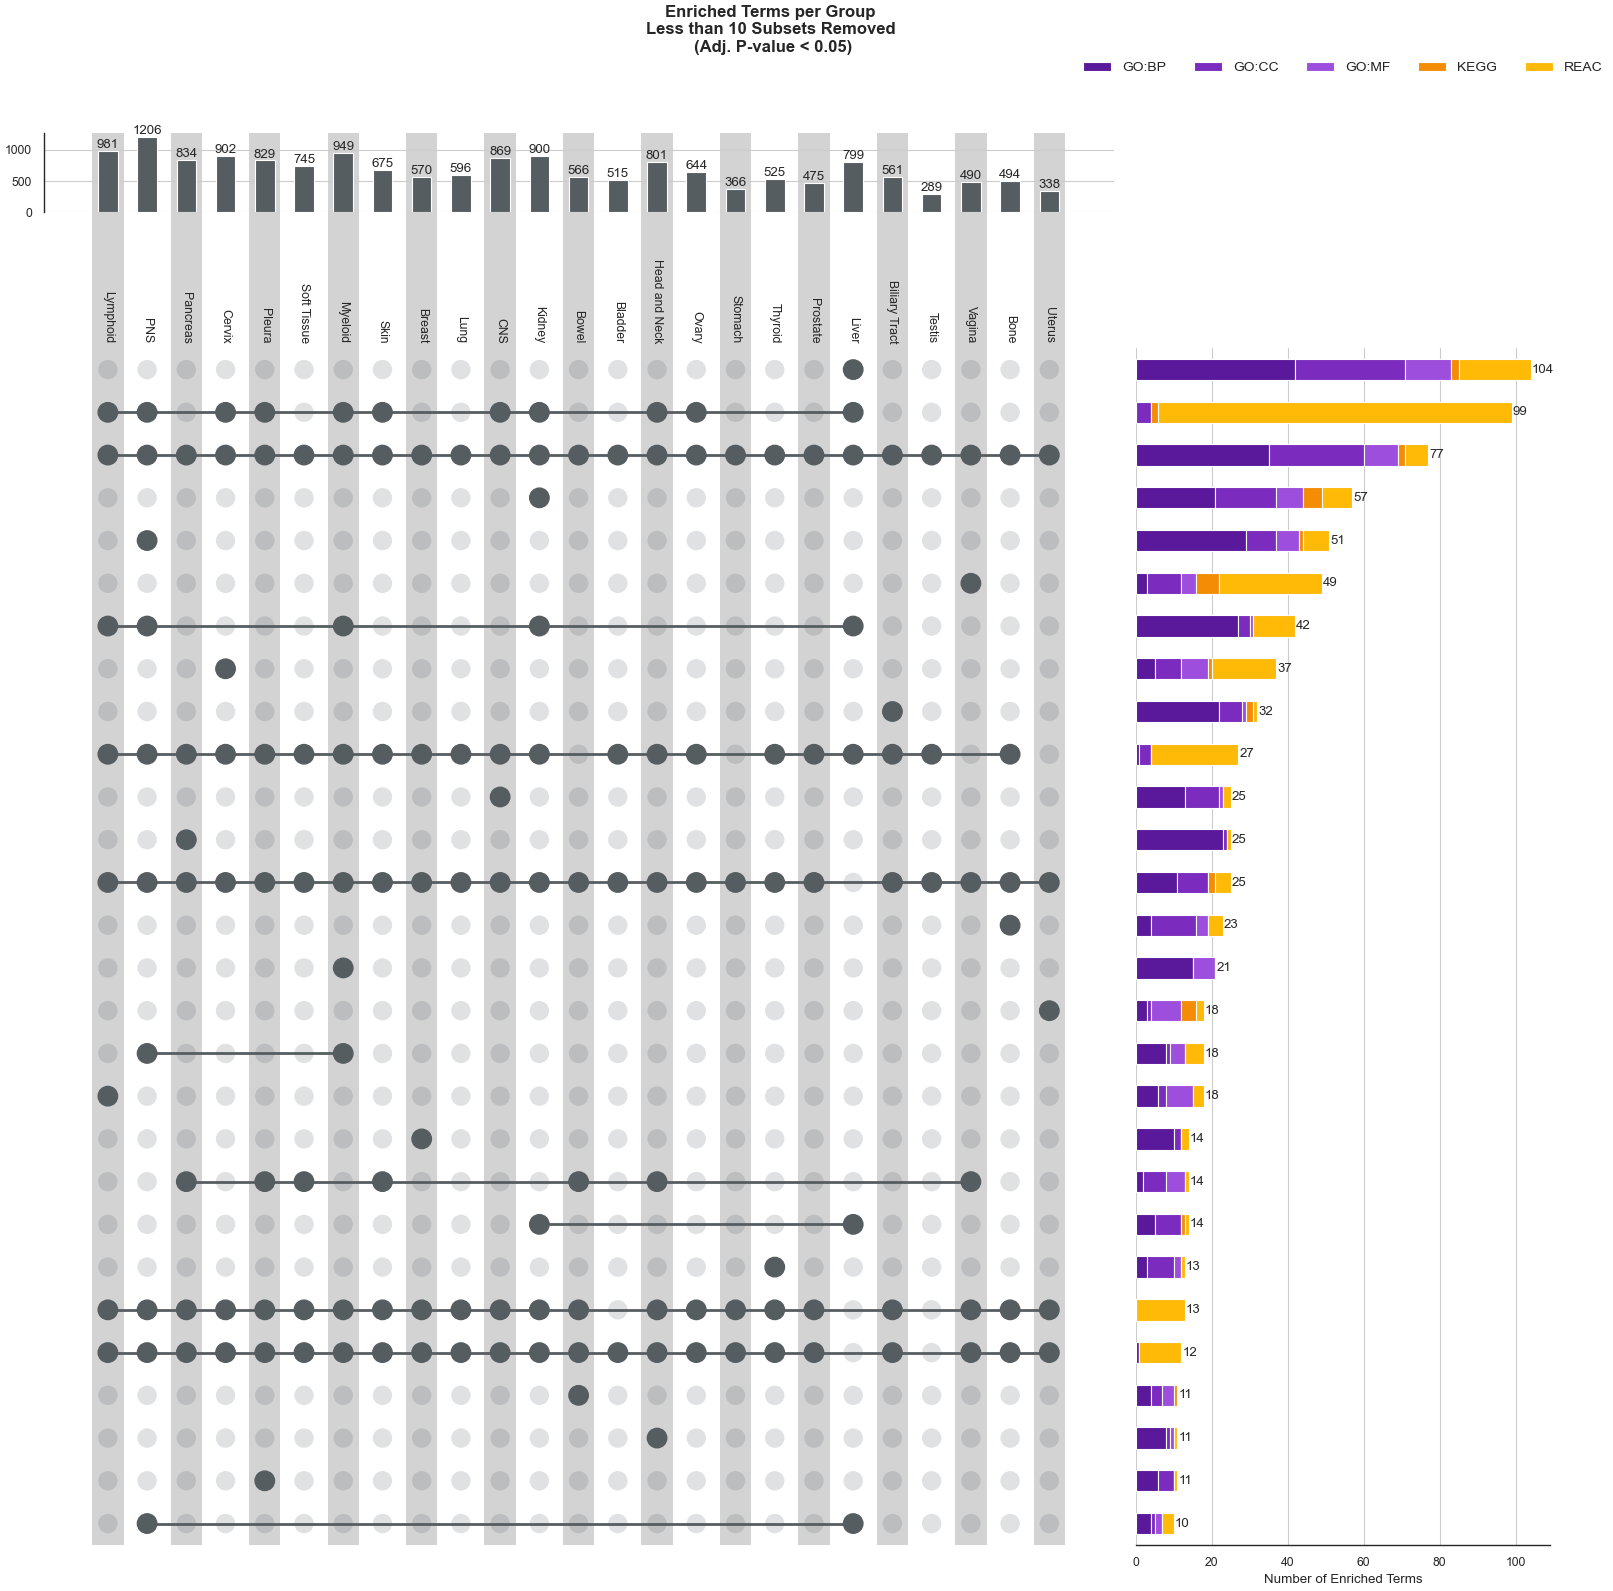

In [31]:
plots.enrich_terms_upset(
    data = subset_gp_res.copy(),
    stacked = True,
    bars_ylabel = "Number of Enriched Terms",
    fig_title = f"Enriched Terms per Group \nLess than 10 Subsets Removed \n(Adj. P-value < {e_pval})",
    min_subset_size=10,
    facecolor = def_colors[2],
    shading_color = "lightgray",
    element_size = 40,
    legend_fontsize=10,
    title_fontsize = 12,
    save = save_to_folder,
    filename = f"{analysis_name}_upsetplot",
    filepath = fig_path,
    fileformat = figure_formats,
    dont_show=False
)
utils.print_series(
    subset_gp_res["source"].value_counts(),
    header = f"Number of enriched terms per source with p-val cutoff {e_pval}:",
    tab = 2,
    elements_with_order = sources
)

77 terms are significantly enriched in all tissue groupings, where Liver has the highest number of distinctly enriched terms with 104, which is not that suprising given liver captures very few stable-core proteins, and had a chunk of distinctly stable proteins. Apart from that, there are intersections where all 24 tissue groups enriched with the exception of liver with 25 terms, and 13 with bladder, testis, and liver missing, and 12 with testis and liver missing.

The things we can learn from this plot is very limited, but wanted to include this in the summary to show the number of enriched terms by query and term source.

#### Heatmap of Enrichment Results

The heatmap is used to highlight the enriched terms by query and term source. The heatmap is created with the -log10 of the p-values or one of the the enrichment scores.

**Heatmap of Enrichment Results**

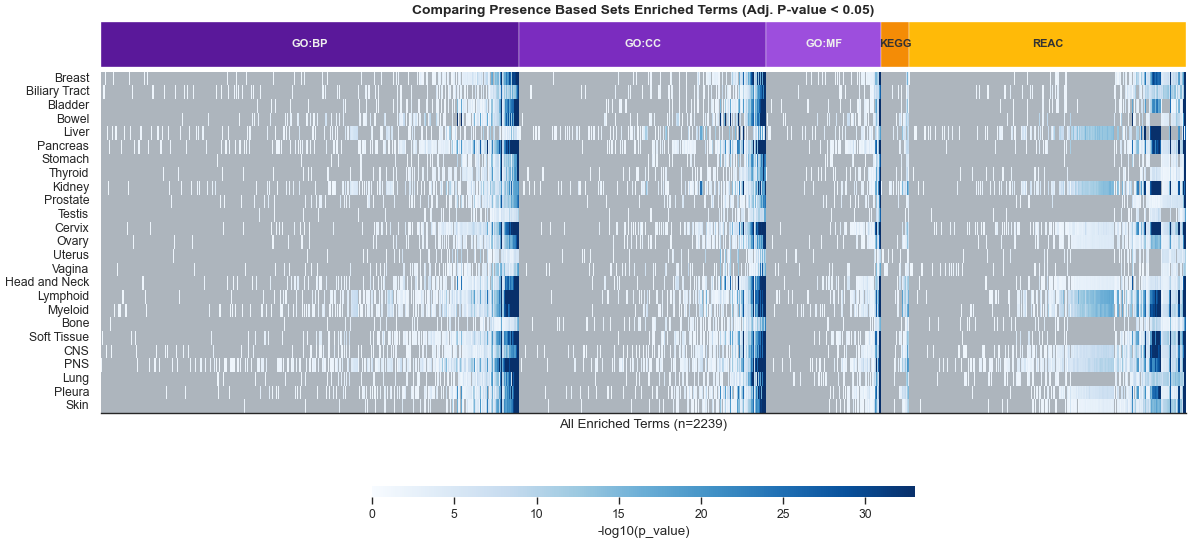

In [32]:
plots.enrich_term_grouped_heatmap(
    data = subset_gp_res.copy(),
    queries = queries,
    sources = sources,
    quant_col = "-log10(p_value)",
    figsize=(14, 7),
    min_count = 10,
    title=f"Comparing Presence Based Sets Enriched Terms (Adj. P-value < {e_pval})",
    filename = f"{analysis_name}_Heatmap",
    filepath = fig_path,
    fileformat = figure_formats,
    dont_show=False
)

### Looking at the KEGG Results 

The KEGG is a database of biological pathways.  It is one of the most popular pathway databases and used in many different applications. In the manuscript I am using KEGG and Reactome to explore the biological relevance of the proteins identified as quantitatively stable and variable in different settings.

Here is all significantly enriched kegg terms in one table since they are only 7 of the.

In [33]:
kegg_data = subset_gp_res.loc[
    subset_gp_res["source"] == "KEGG", 
    [
        "query", "native", "name", 
        "term_size", "intersection_size", 
        "Enrichment", "GeneRatio", 
        "p_value", "p_capped",
        "-log10(p_value)", "-log10(p_capped)",
        "intersections"
    ]
].reset_index(drop=True)
# Remove KEGG root term
kegg_data = kegg_data[kegg_data["native"] != "KEGG:00000"]
# Replace "KEGG:" with hsa
kegg_data["native"] = kegg_data["native"].str.replace("KEGG:", "hsa")
kegg_prot_dict = kegg_data.set_index("name")[
    "intersections"
].str.replace("'", "").str.replace("[", "").str.replace("]", "").str.split(", ").to_dict()

print("Data Shape:", kegg_data.shape)
kegg_data.head()

Data Shape: (368, 12)


query    native         name  term_size  intersection_size  Enrichment  \
0     Lung  hsa03040  Spliceosome        115                 57     20.2038   
1   Breast  hsa03040  Spliceosome        115                 56     18.1732   
2   Cervix  hsa03040  Spliceosome        115                 75      8.6788   
3      PNS  hsa03040  Spliceosome        115                 86      6.0322   
4  Bladder  hsa03040  Spliceosome        115                 64      9.9217   

   GeneRatio  p_value  p_capped  -log10(p_value)  -log10(p_capped)  \
0     0.4957   0.0000    0.0000          60.4611           15.0000   
1     0.4870   0.0000    0.0000          56.2006           15.0000   
2     0.6522   0.0000    0.0000          53.8226           15.0000   
3     0.7478   0.0000    0.0000          51.2803           15.0000   
4     0.5565   0.0000    0.0000          47.5067           15.0000   

                                       intersections  
0  ['O15042', 'O43395', 'Q13573', 'O94906', 'Q994...  
1  ['O15042', 'O43395', 'Q13573', 'O94906', 'Q86X...  
2  ['O15042', 'O43395', 'Q13573', 'O94906', 'Q86X...  
3  ['O15042', 'O43395', 'Q13573', 'O94906', 'Q86X...  
4  ['O15042', 'O43395', 'Q13573', 'O94906', 'Q86X...

Similar to the previous notebook, the Spliceosome is the most dominant pathway that is enriched in most tissue groups. I will further detail and explore the Kegg pathways enriched in tissue groups in two visualizations, in first one I will create a gene ratio based heatmap of the enriched terms and tissue groups, and in the second one will create a detailed dot plot to show the names and overall significance of the enriched terms.

#### KEGG Pathways Heatmap

Subsetted data by source 'KEGG'.
Subsetted data has 392 rows and 21 columns.
There are 58 unique terms in the subsetted data.
Subset by source completed in 00h:00m:00s


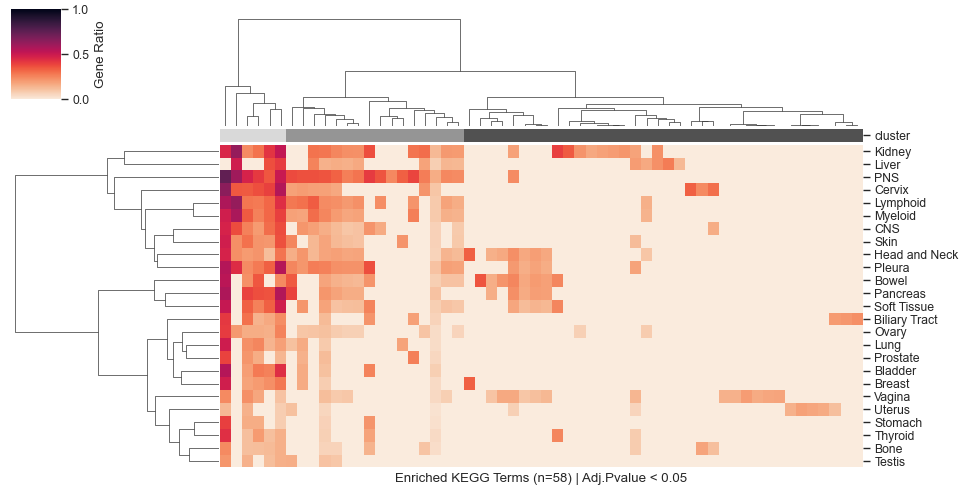

In [34]:
# Variables applied to all sections
source = "KEGG"
name_col = "name"
query_col = "query"
index_col = "native"
source_col = "source"
enrichment_col = "GeneRatio"
pvalue_col = "-log10(p_value)"
# Plotting Variables - Usually passed in each section
number_of_clusters = 3
pick_method = "cluster"
topN = 50
sort_by = "median"
non_significant = True

# Create a subset and exploration copy of the data
subset_data = enrich.subset_by_source(
    data = subset_gp_res,
    source = source,
    source_col = source_col,
    query_col = query_col,
    # Ensure all query are there as well
    query_entries = enrichment_sets.keys(), 
    info_cols = [index_col, name_col],

    # Save a copy of the subset data for exploration
    exploration_copy = False,
    exploration_col = enrichment_col,
    # Save a copy of the subset data for reference
    subset_copy = False,
    save_path = output_path,
    analysis_name = analysis_name,
    # Verbose
    verbose = True
)

subset_data_pivot = subset_data.pivot(
    index = name_col,
    columns = query_col,
    values = enrichment_col
).fillna(0)

clustermap_label = """Enriched {} Terms (n={}) | Adj.Pvalue < {}""".format(
    source,
    subset_data_pivot.shape[0],
    e_pval
)

# Apply clustering to pivot_data
row_clusters, row_linkage = utils.custom_clustering(
    data = subset_data_pivot,
    clustering = "hierarchical",
    nclusters = number_of_clusters,
    method = "ward",
    metric = "euclidean"
)

# Merge row_clusters to the subset_data
subset_data = subset_data.merge(
    row_clusters,
    left_on = name_col,
    right_index = True,
    how = "left"
).sort_values( # Apply a specific sorting to the data
    ["cluster", enrichment_col, pvalue_col],
    ascending = [True, False, True]
)

plots.enrich_term_clustermap(
    data = subset_data_pivot, 
    linkage = row_linkage,
    clusters = row_clusters,
    orientation = "horizontal",
    quant_col = enrichment_col,
    figsize = (10, 5),
    dendrogram_ratio=(.25, .25),
    cbar_pos = (.90, .125, .025, .55),
    cbar_label = "Gene Ratio",
    xlabel = clustermap_label,
    # ylabel = plot_label,
    save = save_to_folder,
    filename = f"{analysis_name}_{source}_Clustermap",
    filepath = fig_path,
    fileformat = figure_formats,
    dont_show = False
)

There are 58 unique kegg pathways enriched in at least one of the tissue groups. The Gene Ratio is used to create the heatmap, where the color represents the gene ratio value. 3 clusters are created from the hierarchical clustering of the columns (enriched kegg terms) The first clusters is the one with most of the tissue groups enrich it, and it should be our focus. It is likely align with what we found in the previous notebook, where metabolism of RNA related pathways are. The second cluster is bit of mix where a lot of high-similarity tissue enriched pathways are there as well as some tissue specific ones. And the third cluster is the one with the least number of tissue groups enriched, which are the tissue specific pathways.

#### KEGG Pathways Dot Plot

The dot plot is constructed to have enriched terms on the y-axis and the query groups are in the x-axis. The dot plot is colored based on the -log10 of the p-value and the size of the dot is based on the gene ratio value. If a term is found but not significantly enriched it is not annotated but left as a simple point, if a term is not even found then it is left empty.

(1245, 21)
Number of unique terms: 58


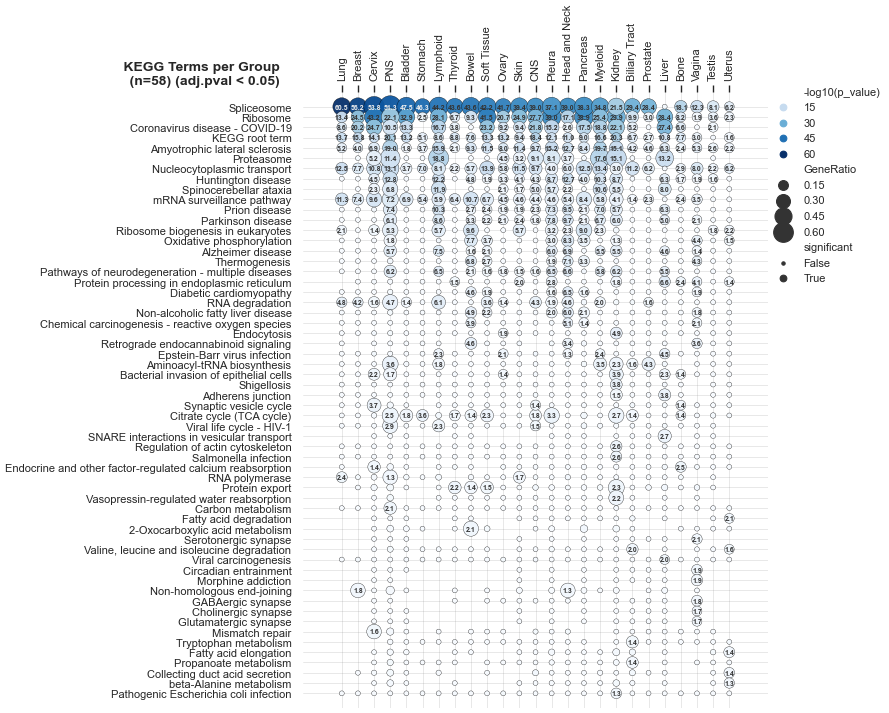

In [35]:
plot_data = utils.pick_terms(
    data = subset_data,
    pivot_data = subset_data_pivot,
    source=source,
    full_data = gp_res,
    name_col = name_col,
    pick_method = pick_method,
    pick_number = topN,
    sort_by = sort_by,
    sort_col = None,
    non_significant=non_significant,
    verbose=False
)
print(plot_data.shape)
print("Number of unique terms:", plot_data["name"].nunique())


# Plot the Dotplot of the topN terms
plots.enrich_dotplot(
    data = plot_data,
    term_col = name_col,
    annotate_method="hue",
    size_col=enrichment_col,
    apply_tight_layout=False,
    figsize=(6, 8),
    sizes=(50, 250),
    size_norm=(0.15, 0.75), 
    hue_norm=(0, 60),
    marker_col="significant",
    color_threshold=45,
    annotate_fontsize=5,
    annotate_fontweight="bold",
    plot_margins=(0.100, 0.025), 
    legend_xypos=(1.125, 1.025),
    grid_alpha=0.25,
    grid_linewidth=0.5,
    grid_color="gray",
    marker_edgecolor="black",
    xlabel_flip=True,
    xtick_flip=True,
    xticklabel_rotation=90,
    title = """
            {} Terms per Group
            (n={}) (adj.pval < {})""".format(
                source,
                plot_data["name"].nunique(),
                e_pval
            ),
    title_loc="right",
    title_pos=(-.05, 1),
    save = save_to_folder,
    filename = f"{analysis_name}_{source}_Top{topN}Terms_Dotplot",
    filepath = fig_path,
    fileformat = figure_formats,
    dont_show = False
)

Spliceosome is found in all except in liver, where Proteosome, is rarely enriched in most groups but in liver. Ribosome is enriched in all but with lower gene ratio and significance overall then spliceosome. Nucleocytoplasmic transport is similar to spliceosome found in all except liver.And mRNA surveillance pathway is found in all except liver and testis and uterus. These are the top 4 pathways that we observed in stable in all cancer cell lines, and they are also enriched in most of the same-tissue groupings.

Other mRNA metabolims related pathwys such as RNA degradation, and RNA polymerase are also enriched handful of tissue groups, for instance RNA polymerase only enriched in lung, PNS and skin. 

In [36]:
## Saving the kegg pathway results to a csv file
print("The KEGG Pathway results are saved as a csv file for supplementary table 2.10")
the_path = f"{supp_path}table_s2_10.csv"
print(f"Filepath: {the_path}")
save_data = plot_data[[
    "query",
    "source", 
    "native", 
    "description",
    "term_size",
    "query_size", 
    "intersection_size",
    "GeneRatio",
    "Enrichment",
    "p_value",
    "-log10(p_value)",
    "intersections",
]]

save_data = save_data[
    save_data["p_value"] < e_pval
]

save_data.to_csv(
    the_path,
    index=False
)

print(f"Data Shape: {save_data.shape}")
save_data.head()

The KEGG Pathway results are saved as a csv file for supplementary table 2.10
Filepath: ./data/supplementary/table_s2_10.csv
Data Shape: (392, 12)


query source      native  description  term_size  query_size  \
108     Lung   KEGG  KEGG:03040  Spliceosome        115         206   
146   Breast   KEGG  KEGG:03040  Spliceosome        115         225   
182   Cervix   KEGG  KEGG:03040  Spliceosome        115         631   
215      PNS   KEGG  KEGG:03040  Spliceosome        115        1041   
274  Bladder   KEGG  KEGG:03040  Spliceosome        115         471   

     intersection_size  GeneRatio  Enrichment  p_value  -log10(p_value)  \
108                 57     0.4957     20.2038   0.0000          60.4611   
146                 56     0.4870     18.1732   0.0000          56.2006   
182                 75     0.6522      8.6788   0.0000          53.8226   
215                 86     0.7478      6.0322   0.0000          51.2803   
274                 64     0.5565      9.9217   0.0000          47.5067   

                                         intersections  
108  ['O15042', 'O43395', 'Q13573', 'O94906', 'Q994...  
146  ['O15042', 'O43395', 'Q13573', 'O94906', 'Q86X...  
182  ['O15042', 'O43395', 'Q13573', 'O94906', 'Q86X...  
215  ['O15042', 'O43395', 'Q13573', 'O94906', 'Q86X...  
274  ['O15042', 'O43395', 'Q13573', 'O94906', 'Q86X...

### Looking at the Reactome Results

The Reactome is a database of biological pathways. Reactome tends to give a lot more hits than KEGG and I wanted to explore it as well. In the manuscript I am using KEGG and Reactome to explore the biological relevance of the proteins identified as quantitatively stable and variable in different settings.

Similar to the KEGG pathway, I will look at the heatmap of the enriched terms and tissue groups, and then create detailed dot plots for each term clusters (since this usually has a lot more terms than KEGG).

#### Reactome Pathways Heatmap

Subsetted data by source 'REAC'.
Subsetted data has 5215 rows and 21 columns.
There are 571 unique terms in the subsetted data.
Subset by source completed in 00h:00m:00s


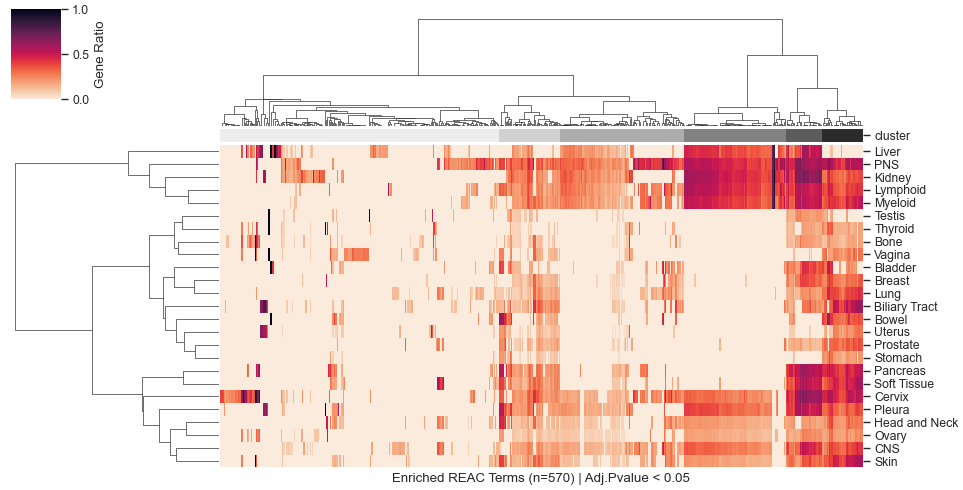

In [37]:
# Variables applied to all sections
source = "REAC"
name_col = "name"
query_col = "query"
index_col = "native"
source_col = "source"
enrichment_col = "GeneRatio"
pvalue_col = "-log10(p_value)"

number_of_clusters = 6
pick_method = "cluster"
topN = 8
sort_by = "median"
non_significant = True

# Create a subset and exploration copy of the data
subset_data = enrich.subset_by_source(
    data = subset_gp_res,
    source = source,
    source_col = source_col,
    query_col = query_col,
    # Ensure all query are there as well
    query_entries = enrichment_sets.keys(), 
    info_cols = [index_col, name_col],

    # Save a copy of the subset data for exploration
    exploration_copy = False,
    exploration_col = enrichment_col,
    # Save a copy of the subset data for reference
    subset_copy = False,
    save_path = output_path,
    analysis_name = analysis_name,
    # Verbose
    verbose = True
)

# Create a pivot table for the clustering
subset_data_pivot = subset_data.pivot(
    index = name_col,
    columns = query_col,
    values = enrichment_col
).fillna(0)

clustermap_label = """Enriched {} Terms (n={}) | Adj.Pvalue < {}""".format(
    source,
    subset_data_pivot.shape[0],
    e_pval
)

# Apply clustering to pivot_data
row_clusters, row_linkage = utils.custom_clustering(
    data = subset_data_pivot,
    clustering = "hierarchical",
    nclusters = number_of_clusters,
    method = "ward",
    metric = "euclidean"
)

# Merge row_clusters to the subset_data
subset_data = subset_data.merge(
    row_clusters,
    left_on = name_col,
    right_index = True,
    how = "left"
).sort_values( # Apply a specific sorting to the data
    ["cluster", enrichment_col, pvalue_col],
    ascending = [True, False, True]
)

plots.enrich_term_clustermap(
    data = subset_data_pivot, 
    linkage = row_linkage,
    clusters = row_clusters,
    orientation = "horizontal",
    quant_col = enrichment_col,
    figsize = (10, 5),
    dendrogram_ratio=(.25, .25),
    cbar_pos = (.90, .125, .025, .55),
    cbar_label = "Gene Ratio",
    xlabel = clustermap_label,
    # ylabel = plot_label,
    save = save_to_folder,
    filename = f"{analysis_name}_{source}_Clustermap",
    filepath = fig_path,
    fileformat = figure_formats,
    dont_show = False
)

(1084, 21)
Number of unique terms: 48


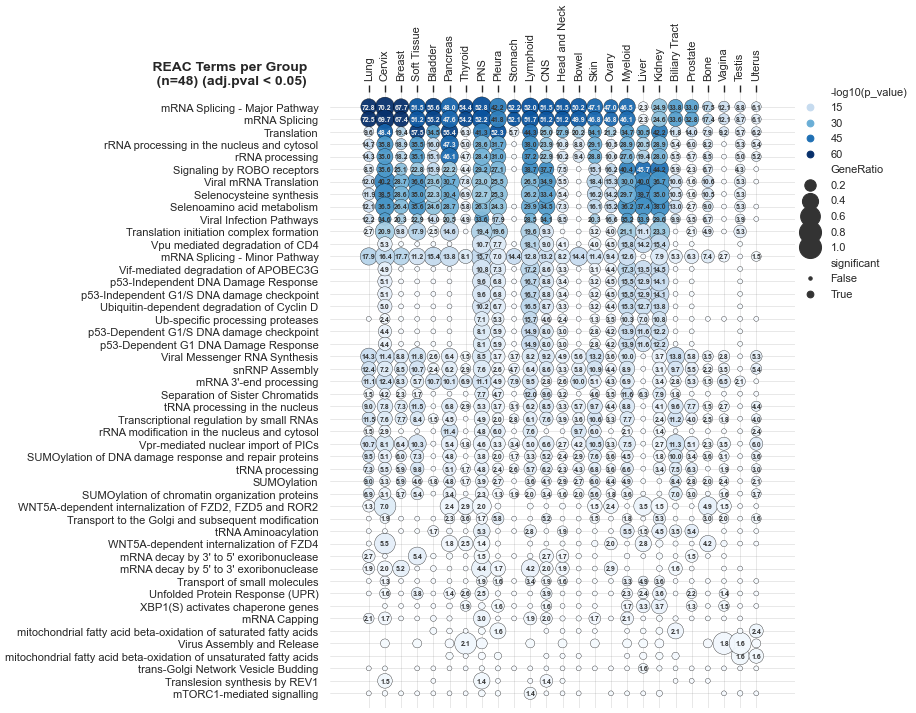

In [38]:
plot_data = utils.pick_terms(
    data = subset_data,
    pivot_data = subset_data_pivot,
    source=source,
    full_data = gp_res,
    name_col = name_col,
    pick_method = pick_method,
    pick_number = topN,
    sort_by = sort_by,
    sort_col = None,
    non_significant=non_significant,
    verbose=False
)
print(plot_data.shape)
print("Number of unique terms:", plot_data["name"].nunique())


# Plot the Dotplot of the topN terms
plots.enrich_dotplot(
    data = plot_data,
    term_col = name_col,
    annotate_method="hue",
    size_col=enrichment_col,
    apply_tight_layout=False,
    figsize=(6, 8),
    sizes=(50, 250),
    size_norm=(0.15, 0.75), 
    hue_norm=(0, 60),
    marker_col="significant",
    color_threshold=45,
    annotate_fontsize=5,
    annotate_fontweight="bold",
    plot_margins=(0.100, 0.025), 
    legend_xypos=(1.125, 1.025),
    grid_alpha=0.25,
    grid_linewidth=0.5,
    grid_color="gray",
    marker_edgecolor="black",
    xlabel_flip=True,
    xtick_flip=True,
    xticklabel_rotation=90,
    title = """
            {} Terms per Group
            (n={}) (adj.pval < {})""".format(
                source,
                plot_data["name"].nunique(),
                e_pval
            ),
    title_loc="right",
    title_pos=(-.05, 1),
    save = save_to_folder,
    filename = f"{analysis_name}_{source}_Top{topN}Terms_Dotplot",
    filepath = fig_path,
    fileformat = figure_formats,
    dont_show = False
)

#### Main Parent Pathway Grouped Exploration

Because the reactome gives tons of hits per same tissue groupings, it is hard to makes sensce of the data on the fly. So I've decided to check how many child-pahtways enriched per group using Rectome's pathway hierarchy. This would be an easy start to see which pathways are enriched then individually child-pathways can be explored. 

For this I use the `ReactomeDetailed.txt` file that contains detailed pathway hierarchy information prepared in the first notebook. 

In [38]:
reactome_reference = pd.read_csv(
    f"{data_path}raw/ReactomeDetailed.txt", 
    sep="\t"
)
reactome_reference["Parent"] = reactome_reference["Parent"].replace(np.nan, "Top Level")
term_dict = reactome_reference.set_index("PathwayID")["Parent"].to_dict()

def recursive_find(term, term_dict):
    # If the term is not in the dictionary, it is a "Top Level" parent
    if term not in term_dict:
        return term
    # If the parent of the term is a "Top Level" parent, return the term
    elif term_dict[term] not in term_dict:
        return term
    # Otherwise, continue with the parent of the term
    else:
        return recursive_find(term_dict[term], term_dict)
    
signf_react_data = subset_data.sort_values(
    ["-log10(p_capped)"], 
    ascending=False
).copy()

signf_react_data = signf_react_data[[
    "query",
    "source", 
    "name",
    "native", 
    "description",
    "term_size",
    "query_size", 
    "intersection_size",
    "GeneRatio",
    "Enrichment",
    "p_value",
    "-log10(p_value)",
    "-log10(p_capped)",
    "intersections",
]]

signf_react_data["native"] = signf_react_data["native"].str.replace("REAC:", "").str.strip()

# Identify the main parent pathway for given pathways
signf_react_data["Group"] = signf_react_data["native"].apply(
    lambda x: recursive_find(x, term_dict)
)
# # If native and Group is the same replace Group with "Top Level"
# signf_react_data.loc[
#     signf_react_data["native"] == signf_react_data["Group"], "Group"
# ] = "Top Level"

signf_react_data["Group Label"] = signf_react_data["Group"].map(
    reactome_reference.set_index("PathwayID")["PathwayName"]
)

plot_data = signf_react_data.groupby(["query", "Group Label"]).size().unstack().fillna(0).astype(int)

plot_data.columns

parent_counts = reactome_reference.loc[
    reactome_reference["Parent"] == "Top Level",
    ["PathwayName", "NumChildren"]
].set_index("PathwayName").loc[plot_data.columns]

# Each column is a group divide each column by the number of children
plot_data_pct = plot_data.divide(parent_counts["NumChildren"], axis=1) * 100

plot_data_pct.columns = plot_data_pct.columns.map(
    # Add the count n= to the column name
    lambda x: x + " (n="+str(parent_counts["NumChildren"].to_dict()[x])+")"
)

print("Previewing the top 25 entries in queried main pathway sizes:")
signf_react_data.groupby(["query", "Group Label"]).size().sort_values(ascending=False).head(25)

Previewing the top 25 entries in queried main pathway sizes:


query          Group Label           
Cervix         Disease                   64
PNS            Disease                   61
Lymphoid       Disease                   59
Myeloid        Disease                   56
PNS            Cell Cycle                54
CNS            Disease                   53
Kidney         Disease                   52
Lung           Disease                   51
Skin           Disease                   51
Cervix         Cell Cycle                50
Lymphoid       Cell Cycle                50
CNS            Cell Cycle                50
Myeloid        Cell Cycle                49
PNS            Metabolism of proteins    49
Ovary          Disease                   48
Head and Neck  Cell Cycle                46
Lymphoid       Metabolism of proteins    45
Pleura         Cell Cycle                45
Skin           Cell Cycle                45
Kidney         Cell Cycle                44
Myeloid        Metabolism of proteins    44
PNS            Signal Transduction    

There are two ways to show them in a heatmap, one using the number of child-pathways enriched per group directly however this will be biased towards the tissue groups that have more enriched pathways. The other way is to a proportion of child-pathways enriched per group. This would be normalized with the number of enriched pathways per group and give a better idea of the proportion of child-pathways enriched per group.

Let me first show the heatmap of the number of child-pathways enriched per group. X-axis will contain the tissue groups and y-axis will contain the main parent pathways. The color map will indicate the number of child-pathways enriched per group, darker the purple more child-pathways enriched per group.

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


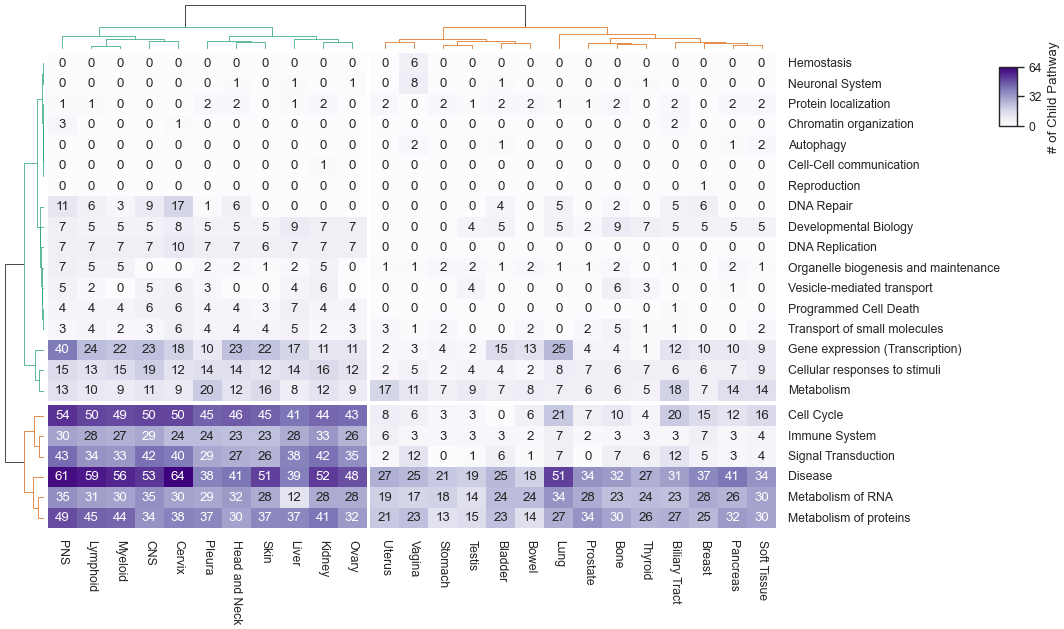

In [39]:
# Create the Clustermap (PyComplexHeatmap)
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10, 6),
)

res = pch.ClusterMapPlotter(
    data = plot_data.T,
    # vmin = 0,
    # vmax = 75,
    cmap = "Purples",

    # Row 
    row_cluster=True,
    row_cluster_method="ward",
    row_cluster_metric="euclidean",
    show_rownames=True,
    row_split=2,
    row_split_gap=1,
    row_dendrogram=True,

    # Column
    col_cluster=True,
    col_cluster_method="ward",
    col_cluster_metric="euclidean",
    show_colnames=True,
    col_split=2,
    col_split_gap=1,
    col_dendrogram=True,

    # Labels
    label="# of Child Pathway",
    tree_kws={
        'row_cmap': 'Dark2',
        'col_cmap': 'Dark2',
    }, 
    # Annotations
    annot=True,
)

Disease (mostly viral pathways), metabolism of RNA and Protein main pathways are the ones that have enriched with minimum of 12 to maximum of 64 in various tissue groups. Cell cycle, immune system and signal transduction are other main pathways that have a lot oenriched child-pathawys in high similarity tissue groups. Rest of the main-pathways are enriched in fewer tisssue groups or lower number of child-pathways enriched in them. 

Let's now look at the proportion of child-pathways enriched per group. X-axis will contain the tissue groups and y-axis will contain the main parent pathways. The color map will indicate the proportion of child-pathways enriched per group, darker the purple more child-pathways enriched per group.

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


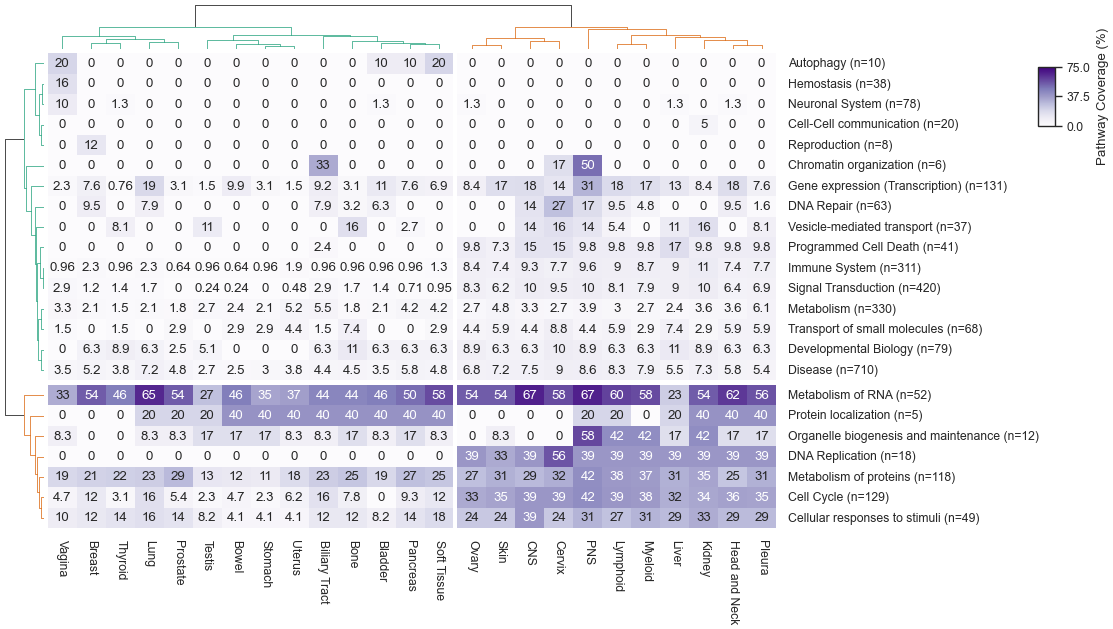

In [40]:
# Create the Clustermap (PyComplexHeatmap)
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10, 6),
)

res = pch.ClusterMapPlotter(
    data = plot_data_pct.T,
    vmin = 0,
    vmax = 75,
    cmap = "Purples",

    # Row 
    row_cluster=True,
    row_cluster_method="ward",
    row_cluster_metric="euclidean",
    show_rownames=True,
    row_split=2,
    row_split_gap=1,
    row_dendrogram=True,

    # Column
    col_cluster=True,
    col_cluster_method="ward",
    col_cluster_metric="euclidean",
    show_colnames=True,
    col_split=2,
    col_split_gap=1,
    col_dendrogram=True,

    # Labels
    label="Pathway Coverage (%)",
    tree_kws={
        'row_cmap': 'Dark2',
        'col_cmap': 'Dark2',
    }, 
    # Annotations
    annot=True,
)

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"{analysis_name}_ReactomePathwayCoverage",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

This is a better view where huge main-parent pathways like Disease looks not as heavily enriched anymore. However main-parent pathway such as metabolism of RNA that we found to be abundanlty enriched is still with higher coveraged over most of the tissues. 

**Metabolism of RNA Dot Plot**

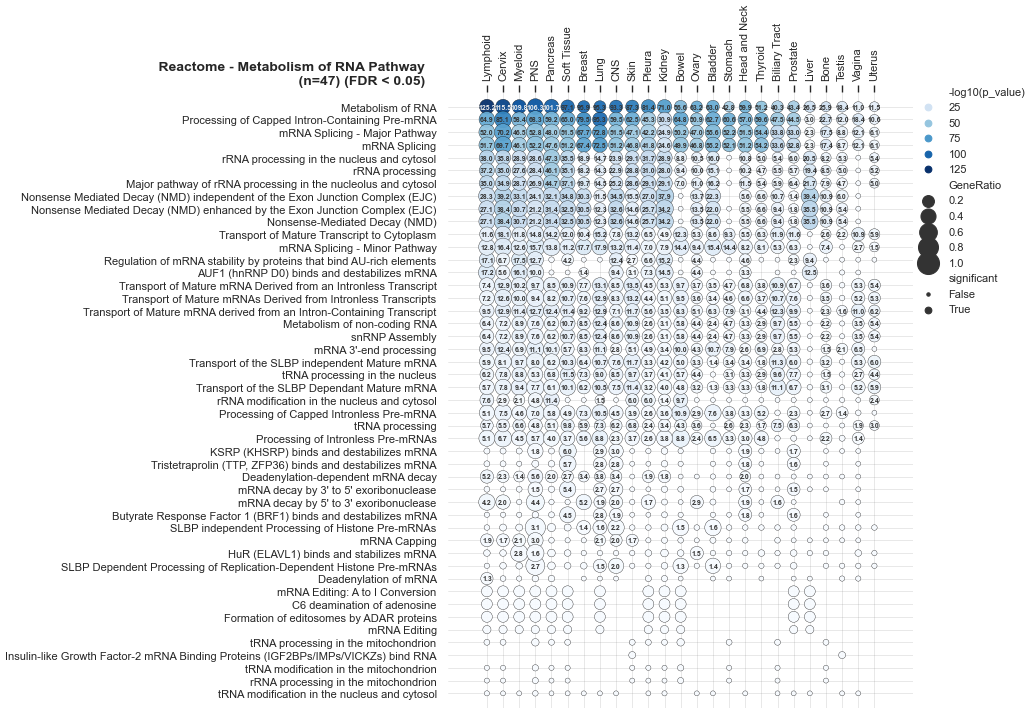

In [41]:
cur_pathway_name = "Metabolism of RNA"
plot_data = gp_res.loc[
    (gp_res["source"]=="REAC"), 
    [
        "query", "native", "name", "significant", "term_size", "intersection_size", "-log10(p_value)", "GeneRatio",
    ]
]

plot_data["native"] = plot_data["native"].str.replace("REAC:", "")
# Map the Main-Parent terms
plot_data["parent"] = plot_data["native"].map(
    reactome_reference.set_index("PathwayID")["Parent"]
)

# Identify the main parent pathway for given pathways
plot_data["Group"] = plot_data["native"].apply(
    lambda x: recursive_find(x, term_dict)
)
plot_data["Group Label"] = plot_data["Group"].map(
    reactome_reference.set_index("PathwayID")["PathwayName"]
)

plot_data = plot_data[plot_data["Group Label"] == cur_pathway_name]

# Plot the Dotplot of the topN terms
plots.enrich_dotplot(
    data = plot_data,
    term_col = "name",
    annotate_method="hue",
    size_col="GeneRatio",
    apply_tight_layout=False,
    figsize=(6, 8),
    sizes=(50, 250),
    size_norm=(0.1, 1), 
    hue_norm=(1, 125),
    marker_col="significant",
    color_threshold=100,
    annotate_fontsize=5,
    annotate_fontweight="bold",
    plot_margins=(0.100, 0.025), 
    legend_xypos=(1.125, 1.025),
    grid_alpha=0.25,
    grid_linewidth=0.5,
    grid_color="gray",
    marker_edgecolor="black",
    xlabel_flip=True,
    xtick_flip=True,
    xticklabel_rotation=90,
    title = """
            Reactome - {} Pathway
            (n={}) (FDR < {})""".format(
                cur_pathway_name,
                plot_data["name"].nunique(),
                e_pval
            ),
    title_loc="right",
    title_pos=(-.05, 1),
    save = save_to_folder,
    filename = f"{analysis_name}_{source}_{cur_pathway_name}_Dotplot",
    filepath = fig_path,
    fileformat = figure_formats,
    dont_show = False
)

A detailed dot plot that is showing reactome pathways from only the Metabolism of RNA main-parent pathway. 

Here we can see the pathways that are enriched in all and most tissues, while there are also some pathways with few tissue groups enrichment. And at the end there are pathawys that are found (at least one protein matched) but not significanly enriched such as mRNA editing, tRNA mod in mitochondrion, etc. 


#### Save the Enrichment Results As Supplementary Data

In [42]:
## Saving the kegg pathway results to a csv file
print("The Reactome Pathway results are saved as a csv file for supplementary table 2.11")
the_path = f"{supp_path}table_s2_11.csv"
print(f"Filepath: {the_path}")

save_data = signf_react_data.drop(
    columns=["Group", "Group Label", "-log10(p_capped)", "name"]
)

save_data.to_csv(
    the_path,
    index=False
)

print(f"Data Shape: {save_data.shape}")
save_data.head()

The Reactome Pathway results are saved as a csv file for supplementary table 2.11
Filepath: ./data/supplementary/table_s2_11.csv
Data Shape: (5215, 12)


query source         native  \
2246   Myeloid   REAC    R-HSA-75815   
2105  Lymphoid   REAC    R-HSA-69541   
235      Bowel   REAC    R-HSA-72172   
1232    Pleura   REAC  R-HSA-2408557   
1297     Liver   REAC  R-HSA-1266738   

                                      description  term_size  query_size  \
2246  Ubiquitin-dependent degradation of Cyclin D         48         515   
2105                         Stabilization of p53         48         581   
235                                 mRNA Splicing        195         494   
1232                     Selenocysteine synthesis         83         691   
1297                        Developmental Biology        599         460   

      intersection_size  GeneRatio  Enrichment  p_value  -log10(p_value)  \
2246                 24     0.5000      8.1524   0.0000          15.2979   
2105                 26     0.5417      7.8285   0.0000          16.4592   
235                  84     0.4308      7.3222   0.0000          49.9120   
1232                 45     0.5422      6.5884   0.0000          25.2920   
1297                102     0.1703      3.1084   0.0000          24.4604   

                                          intersections  
2246  ['Q99460', 'P35998', 'P25786', 'P62333', 'P436...  
2105  ['P55036', 'Q99460', 'P35998', 'P25786', 'P623...  
235   ['O15042', 'Q14498', 'O43395', 'Q13573', 'Q082...  
1232  ['P62913', 'P50914', 'P62851', 'P61247', 'P233...  
1297  ['P36578', 'P35221', 'P05386', 'P62913', 'P509...

# Conclusion

In this notebook I've used the `questvar`'s statistical testing summary tables and explore the quantitative stability and variability within same-tissue groupings created by subsetting cell line pairing originate from the same tissue. This provides us to explore different questions such as what is the within tissue conservation rate of proteins, what are the proteins stable and variable within same tissue cancer types, and their biological relevance. As well as checking if the overlap between stable proteins identified at all cell levels vs same-tissue. 

I also presented some high-level and detailed summary on the gprofiler's multi-query enrichement results that can be used along-side questvar or any enrichment sets.

In [43]:
print("Notebook Execution Time:", utils.prettyTimer(utils.getTime() - nbStartTime))

Notebook Execution Time: 00h:03m:05s
